# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010],
        [-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010],
        [-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010],
        ...,
        [-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010],
        [-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010],
        [-0.0060, -0.0022, -0.0104,  ...,  0.0171, -0.0031,  0.0010]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=100,
    patience=10 # For the early stopping
)

Epoch 1/100 (Train):   0%|                                                                               | 0/525 [00:00<?, ?it/s]

responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 1.000062346458435 0.9699158072471619 1.0385372638702393
-----
loss:  tensor(6.9580, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   1%|▋                                                                      | 5/525 [00:00<00:39, 13.12it/s]

responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 1.0020745992660522 0.8897985219955444 1.1399824619293213
-----
loss:  tensor(6.9529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 1.0046873092651367 0.8761524558067322 1.1169312000274658
-----
loss:  tensor(4.7472, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 1.0064488649368286 0.9543581008911133 1.0522798299789429
-----
loss:  tensor(5.6387, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 1.0083814859390259 0.9366009831428528 1.0791279077529907
-----
loss:  tensor(7.4810, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1595003604888916 0.0 89.9400405883789
predictions mean/min/max: 1.0102659463882446 0.8997183442115784 1.120

Epoch 1/100 (Train):   2%|█▋                                                                    | 13/525 [00:00<00:19, 25.71it/s]

responses mean/min/max: 2.8166394233703613 0.0 119.8402099609375
predictions mean/min/max: 1.0188424587249756 0.9214025139808655 1.0978381633758545
-----
loss:  tensor(6.7191, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.376952648162842 0.0 119.76048278808594
predictions mean/min/max: 1.0210590362548828 0.8870605230331421 1.136652946472168
-----
loss:  tensor(10.0123, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 1.0235521793365479 0.8981778621673584 1.1739749908447266
-----
loss:  tensor(8.9631, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 1.0261017084121704 0.9011071920394897 1.1717251539230347
-----
loss:  tensor(8.1123, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 1.0289359092712402 0.9090824127197266 1.1

Epoch 1/100 (Train):   5%|███▍                                                                  | 26/525 [00:00<00:14, 35.29it/s]

responses mean/min/max: 2.711289644241333 0.0 149.7504119873047
predictions mean/min/max: 1.0417181253433228 0.8980469107627869 1.1354906558990479
-----
loss:  tensor(6.4570, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9228768348693848 0.0 119.8402099609375
predictions mean/min/max: 1.0442174673080444 0.8873745203018188 1.133815050125122
-----
loss:  tensor(6.8213, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2682008743286133 0.0 89.88015747070312
predictions mean/min/max: 1.0464942455291748 0.8970864415168762 1.1175566911697388
-----
loss:  tensor(5.3704, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 1.0487781763076782 0.8925136923789978 1.1135213375091553
-----
loss:  tensor(5.7948, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 1.0509936809539795 0.886155903339386 1.1431757211

Epoch 1/100 (Train):   6%|████▏                                                                 | 31/525 [00:01<00:12, 38.36it/s]

responses mean/min/max: 2.2412071228027344 0.0 119.8402099609375
predictions mean/min/max: 1.0600985288619995 0.8754862546920776 1.13532555103302
-----
loss:  tensor(5.3074, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.063704490661621 0.0 159.62753295898438
predictions mean/min/max: 1.062391757965088 0.8674882054328918 1.156872272491455
-----
loss:  tensor(9.3139, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.336756706237793 0.0 110.110107421875
predictions mean/min/max: 1.0648502111434937 0.8631486892700195 1.1627565622329712
-----
loss:  tensor(7.4995, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 1.0673308372497559 0.8616787195205688 1.161095380783081
-----
loss:  tensor(8.1773, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 1.0698729753494263 0.8560399413108826 1.1625593

Epoch 1/100 (Train):   8%|█████▎                                                                | 40/525 [00:01<00:12, 38.32it/s]

responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 1.0819460153579712 0.8365879654884338 1.1846843957901
-----
loss:  tensor(7.8572, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4881927967071533 0.0 140.0
predictions mean/min/max: 1.0842829942703247 0.8316284418106079 1.1920723915100098
-----
loss:  tensor(5.7821, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.763470411300659 0.0 149.45201110839844
predictions mean/min/max: 1.0865042209625244 0.8263739347457886 1.1919957399368286
-----
loss:  tensor(8.6577, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 1.0888502597808838 0.8278072476387024 1.1989123821258545
-----
loss:  tensor(7.3901, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 1.0911718606948853 0.8192617893218994 1.2046117782592773


Epoch 1/100 (Train):   9%|██████▌                                                               | 49/525 [00:01<00:11, 40.69it/s]

responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 1.1003782749176025 0.8038735389709473 1.2331299781799316
-----
loss:  tensor(8.0526, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 1.1027607917785645 0.804102897644043 1.2233219146728516
-----
loss:  tensor(7.1320, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 1.1050983667373657 0.8029365539550781 1.2252163887023926
-----
loss:  tensor(6.0494, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 1.1073646545410156 0.7942332029342651 1.2302987575531006
-----
loss:  tensor(8.7796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5142250061035156 0.0 140.2337188720703
predictions mean/min/max: 1.1097687482833862 0.7868103981018066 1

Epoch 1/100 (Train):  11%|███████▊                                                              | 59/525 [00:01<00:11, 41.80it/s]

tensor(5.1374, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.543308734893799 0.0 129.826904296875
predictions mean/min/max: 1.122693419456482 0.7657062411308289 1.261338710784912
-----
loss:  tensor(7.6113, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 1.1246919631958008 0.7684157490730286 1.2651864290237427
-----
loss:  tensor(6.5962, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 1.1267428398132324 0.7648236751556396 1.269818663597107
-----
loss:  tensor(8.1027, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 1.128833532333374 0.758017897605896 1.2780442237854004
-----
loss:  tensor(7.4721, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.417120933532715 0.0 119.80033111572266
predictions mean/

Epoch 1/100 (Train):  13%|█████████▏                                                            | 69/525 [00:02<00:11, 41.18it/s]

responses mean/min/max: 3.6067354679107666 0.0 129.826904296875
predictions mean/min/max: 1.139788269996643 0.7463555335998535 1.3037444353103638
-----
loss:  tensor(7.6029, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8610479831695557 0.0 79.86688995361328
predictions mean/min/max: 1.142144799232483 0.7440369725227356 1.3150279521942139
-----
loss:  tensor(5.8686, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8241801261901855 0.0 99.63467407226562
predictions mean/min/max: 1.144424319267273 0.742581844329834 1.3076831102371216
-----
loss:  tensor(6.2321, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 1.146572232246399 0.734673261642456 1.310766577720642
-----
loss:  tensor(7.9167, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 1.148808240890503 0.7289384007453918 1.3200008869

Epoch 1/100 (Train):  14%|█████████▊                                                            | 74/525 [00:02<00:10, 41.16it/s]

responses mean/min/max: 3.3311898708343506 0.0 149.8501434326172
predictions mean/min/max: 1.1606682538986206 0.7174910306930542 1.3403375148773193
-----
loss:  tensor(6.8163, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.371873617172241 0.0 109.85353088378906
predictions mean/min/max: 1.1631059646606445 0.713437557220459 1.3455710411071777
-----
loss:  tensor(5.1484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.895944356918335 0.0 160.16015625
predictions mean/min/max: 1.1654045581817627 0.7125107049942017 1.3458913564682007
-----
loss:  tensor(8.6013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions mean/min/max: 1.1679109334945679 0.710663914680481 1.3541018962860107
-----
loss:  tensor(5.4616, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 1.1701908111572266 0.6982163786888123 1.362297534

Epoch 1/100 (Train):  16%|███████████▏                                                          | 84/525 [00:02<00:11, 39.40it/s]

responses mean/min/max: 3.046682119369507 0.0 199.66722106933594
predictions mean/min/max: 1.181030511856079 0.6902840733528137 1.374426007270813
-----
loss:  tensor(6.6916, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 1.1830464601516724 0.6873579025268555 1.384806752204895
-----
loss:  tensor(7.9141, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.249040126800537 0.0 149.45201110839844
predictions mean/min/max: 1.1851643323898315 0.6780796647071838 1.391817569732666
-----
loss:  tensor(7.2278, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8866217136383057 0.0 109.74393463134766
predictions mean/min/max: 1.187330961227417 0.6764636039733887 1.3916631937026978
-----
loss:  tensor(6.0571, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9896082878112793 0.0 190.190185546875
predictions mean/min/max: 1.1893945932388306 0.673751175403595 1.39311397

Epoch 1/100 (Train):  18%|████████████▌                                                         | 94/525 [00:02<00:10, 39.45it/s]

responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 1.1975140571594238 0.6628515720367432 1.409481167793274
-----
loss:  tensor(6.7911, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 1.1995714902877808 0.6655120253562927 1.4186780452728271
-----
loss:  tensor(7.4362, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.17523193359375 0.0 129.7405242919922
predictions mean/min/max: 1.2017499208450317 0.6646448969841003 1.422299861907959
-----
loss:  tensor(9.0943, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 1.204087495803833 0.6582488417625427 1.4223129749298096
-----
loss:  tensor(6.6315, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 1.2063640356063843 0.6549858450889587 1.42662

Epoch 1/100 (Train):  19%|█████████████▍                                                       | 102/525 [00:02<00:10, 39.24it/s]

responses mean/min/max: 3.068246841430664 0.0 119.96001434326172
predictions mean/min/max: 1.2143571376800537 0.6424741744995117 1.4482488632202148
-----
loss:  tensor(6.5934, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 1.2162959575653076 0.6379097104072571 1.4576067924499512
-----
loss:  tensor(6.8419, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 1.2182364463806152 0.6363027691841125 1.4566340446472168
-----
loss:  tensor(7.0579, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006019353866577 0.0 139.90672302246094
predictions mean/min/max: 1.220210313796997 0.6348317861557007 1.4604829549789429
-----
loss:  tensor(6.5812, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.382957696914673 0.0 159.73377990722656
predictions mean/min/max: 1.2221359014511108 0.6386222839355469 1.464791

Epoch 1/100 (Train):  20%|██████████████                                                       | 107/525 [00:02<00:10, 40.55it/s]

tensor(6.6476, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 1.2319799661636353 0.6240307092666626 1.4798104763031006
-----
loss:  tensor(7.1171, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 1.2339266538619995 0.6210522651672363 1.4856853485107422
-----
loss:  tensor(5.8873, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 1.235906958580017 0.6171503067016602 1.4914305210113525
-----
loss:  tensor(7.6059, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 1.2379677295684814 0.6142977476119995 1.5006599426269531
-----
loss:  tensor(7.2554, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions

Epoch 1/100 (Train):  22%|███████████████▍                                                     | 117/525 [00:03<00:09, 41.01it/s]

responses mean/min/max: 3.058100700378418 0.0 170.170166015625
predictions mean/min/max: 1.2489285469055176 0.5987589359283447 1.5176811218261719
-----
loss:  tensor(6.5422, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.586507797241211 0.0 219.92669677734375
predictions mean/min/max: 1.251061201095581 0.6026540398597717 1.5179202556610107
-----
loss:  tensor(7.4157, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14390230178833 0.0 180.12008666992188
predictions mean/min/max: 1.2532451152801514 0.5954815149307251 1.5210192203521729
-----
loss:  tensor(6.6322, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 1.2554428577423096 0.5922120809555054 1.527418851852417
-----
loss:  tensor(6.7869, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797
predictions mean/min/max: 1.2576062679290771 0.5926778316497803 1.5425455

Epoch 1/100 (Train):  24%|████████████████▋                                                    | 127/525 [00:03<00:09, 41.18it/s]

responses mean/min/max: 4.61008358001709 0.0 139.48854064941406
predictions mean/min/max: 1.2674956321716309 0.5811946392059326 1.5556552410125732
-----
loss:  tensor(9.9778, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5404233932495117 0.0 100.10009765625
predictions mean/min/max: 1.2696146965026855 0.5805069804191589 1.55949068069458
-----
loss:  tensor(7.4583, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.968034505844116 0.0 129.6542510986328
predictions mean/min/max: 1.271799087524414 0.579244077205658 1.5591931343078613
-----
loss:  tensor(6.2449, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9926693439483643 0.0 109.78044128417969
predictions mean/min/max: 1.2740036249160767 0.571991503238678 1.5609110593795776
-----
loss:  tensor(6.3235, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5710597038269043 0.0 139.5812530517578
predictions mean/min/max: 1.276119351387024 0.5679773092269897 1.5715646743

Epoch 1/100 (Train):  26%|██████████████████                                                   | 137/525 [00:03<00:09, 40.09it/s]

responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 1.283814787864685 0.5608996748924255 1.582907795906067
-----
loss:  tensor(6.1393, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 1.2857115268707275 0.5560703277587891 1.5896379947662354
-----
loss:  tensor(6.5344, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 1.2875559329986572 0.5563374161720276 1.59244704246521
-----
loss:  tensor(8.1015, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.121422290802002 0.0 99.93338012695312
predictions mean/min/max: 1.2895041704177856 0.556159257888794 1.5979152917861938
-----
loss:  tensor(6.3719, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.284454822540283 0.0 129.95668029785156
predictions mean/min/max: 1.2914321422576904 0.5564903616905212 1.599510

Epoch 1/100 (Train):  27%|██████████████████▋                                                  | 142/525 [00:03<00:09, 40.72it/s]

responses mean/min/max: 3.5487301349639893 0.0 149.8501434326172
predictions mean/min/max: 1.2992712259292603 0.5473217368125916 1.6228160858154297
-----
loss:  tensor(7.1399, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 1.3011879920959473 0.5444356799125671 1.6228923797607422
-----
loss:  tensor(5.2086, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 1.3029695749282837 0.5402444005012512 1.6231906414031982
-----
loss:  tensor(7.0837, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347028970718384 0.0 129.43910217285156
predictions mean/min/max: 1.3047125339508057 0.5402470231056213 1.6308553218841553
-----
loss:  tensor(6.9425, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2421927452087402 0.0 89.9400405883789
predictions mean/min/max: 1.3065266609191895 0.5375575423240662 1.635685205459594

Epoch 1/100 (Train):  29%|███████████████████▊                                                 | 151/525 [00:04<00:09, 39.67it/s]

responses mean/min/max: 2.45500111579895 0.0 109.85353088378906
predictions mean/min/max: 1.315211296081543 0.5272527933120728 1.656709909439087
-----
loss:  tensor(5.2318, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.344259262084961 0.0 90.06004333496094
predictions mean/min/max: 1.3168874979019165 0.5279864072799683 1.6592559814453125
-----
loss:  tensor(4.6761, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 1.318454384803772 0.5269477367401123 1.6714327335357666
-----
loss:  tensor(4.6219, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 1.319859266281128 0.5185949802398682 1.6705838441848755
-----
loss:  tensor(5.1780, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predictions mean/min/max: 1.3211872577667236 0.5168483257293701 1.669103622

Epoch 1/100 (Train):  30%|█████████████████████                                                | 160/525 [00:04<00:08, 40.79it/s]

responses mean/min/max: 3.2516534328460693 0.0 129.91339111328125
predictions mean/min/max: 1.3269126415252686 0.5120481848716736 1.6827529668807983
-----
loss:  tensor(6.6460, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.923271417617798 0.0 239.0438232421875
predictions mean/min/max: 1.3286240100860596 0.509392261505127 1.6869144439697266
-----
loss:  tensor(8.1412, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913869619369507 0.0 159.68063354492188
predictions mean/min/max: 1.3304712772369385 0.5112977623939514 1.6929469108581543
-----
loss:  tensor(5.9629, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.015129804611206 0.0 99.9666748046875
predictions mean/min/max: 1.3323034048080444 0.5115281939506531 1.698249101638794
-----
loss:  tensor(5.9624, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 1.3340919017791748 0.5057539939880371 1.6998

Epoch 1/100 (Train):  32%|██████████████████████▎                                              | 170/525 [00:04<00:08, 40.41it/s]

responses mean/min/max: 2.9358787536621094 0.0 99.63467407226562
predictions mean/min/max: 1.3429710865020752 0.4995065927505493 1.719010829925537
-----
loss:  tensor(5.8893, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9322359561920166 0.0 99.8668441772461
predictions mean/min/max: 1.3446602821350098 0.49507296085357666 1.721730351448059
-----
loss:  tensor(7.7820, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 1.3464947938919067 0.49197500944137573 1.7248575687408447
-----
loss:  tensor(5.6843, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0164706707000732 0.0 119.80033111572266
predictions mean/min/max: 1.3482496738433838 0.490572452545166 1.7285950183868408
-----
loss:  tensor(6.1023, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 1.3500245809555054 0.4930497407913208 1.73513

Epoch 1/100 (Train):  33%|███████████████████████                                              | 175/525 [00:04<00:08, 40.94it/s]

predictions mean/min/max: 1.357628345489502 0.48537731170654297 1.7453205585479736
-----
loss:  tensor(5.5864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 1.3595385551452637 0.4846852421760559 1.748482584953308
-----
loss:  tensor(6.3108, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 1.3614202737808228 0.48438405990600586 1.7525054216384888
-----
loss:  tensor(5.1918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.881117343902588 0.0 99.8668441772461
predictions mean/min/max: 1.3631757497787476 0.48226332664489746 1.7584691047668457
-----
loss:  tensor(5.8752, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5872414112091064 0.0 89.85025024414062
predictions mean/min/max: 1.364854335784912 0.47821491956710815 1.764007329940796
-----
loss:  tensor(5.3238, device='mps:0', grad_fn

Epoch 1/100 (Train):  35%|████████████████████████▎                                            | 185/525 [00:04<00:08, 41.10it/s]

responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 1.3725574016571045 0.470772922039032 1.7826695442199707
-----
loss:  tensor(4.9435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 1.373950719833374 0.468631386756897 1.7850158214569092
-----
loss:  tensor(5.1690, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 1.375236988067627 0.46729815006256104 1.7876057624816895
-----
loss:  tensor(6.0411, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 1.376579999923706 0.4649198651313782 1.791168212890625
-----
loss:  tensor(5.3992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 1.377905249595642 0.46200209856033325 1.7927682399749756
-----
loss: 

Epoch 1/100 (Train):  37%|█████████████████████████▋                                           | 195/525 [00:05<00:08, 40.88it/s]

responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 1.3851932287216187 0.4570544958114624 1.8082780838012695
-----
loss:  tensor(5.0718, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predictions mean/min/max: 1.386736512184143 0.4562339782714844 1.8108853101730347
-----
loss:  tensor(5.6193, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 1.3882625102996826 0.4543372392654419 1.814110517501831
-----
loss:  tensor(5.4804, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.623264789581299 0.0 119.8402099609375
predictions mean/min/max: 1.3897805213928223 0.4509701728820801 1.8207650184631348
-----
loss:  tensor(5.2649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.801694869995117 0.0 119.76048278808594
predictions mean/min/max: 1.3912105560302734 0.449344277381897 1.82260

Epoch 1/100 (Train):  39%|██████████████████████████▉                                          | 205/525 [00:05<00:07, 40.85it/s]

tensor(7.4018, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.902730703353882 0.0 129.91339111328125
predictions mean/min/max: 1.398105502128601 0.44293642044067383 1.8447470664978027
-----
loss:  tensor(5.9099, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 1.399614691734314 0.43922650814056396 1.8420876264572144
-----
loss:  tensor(5.9807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 1.401119589805603 0.43834853172302246 1.8497591018676758
-----
loss:  tensor(6.8769, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 1.4026892185211182 0.43905937671661377 1.8548333644866943
-----
loss:  tensor(5.4348, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
prediction

Epoch 1/100 (Train):  40%|███████████████████████████▌                                         | 210/525 [00:05<00:07, 41.72it/s]

responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 1.4103025197982788 0.431193470954895 1.869028091430664
-----
loss:  tensor(8.3527, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1214795112609863 0.0 139.5812530517578
predictions mean/min/max: 1.4120866060256958 0.42989814281463623 1.8709239959716797
-----
loss:  tensor(6.2892, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 1.4139052629470825 0.42777198553085327 1.8740947246551514
-----
loss:  tensor(7.1992, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.971151828765869 0.0 129.78369140625
predictions mean/min/max: 1.4157406091690063 0.42707979679107666 1.8806917667388916
-----
loss:  tensor(5.9728, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 1.4175138473510742 0.42542797327041626 1.88

Epoch 1/100 (Train):  42%|████████████████████████████▉                                        | 220/525 [00:05<00:07, 41.09it/s]

responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 1.4254484176635742 0.41861486434936523 1.9017411470413208
-----
loss:  tensor(5.5866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 1.4269156455993652 0.4176079034805298 1.9028747081756592
-----
loss:  tensor(5.3614, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715726613998413 0.0 79.81376647949219
predictions mean/min/max: 1.4283024072647095 0.41651469469070435 1.9091025590896606
-----
loss:  tensor(5.4169, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 1.4296666383743286 0.41499221324920654 1.9138834476470947
-----
loss:  tensor(5.2402, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6457502841949463 0.0 99.90010070800781
predictions mean/min/max: 1.4309395551681519 0.4124029278755188 1

Epoch 1/100 (Train):  44%|██████████████████████████████▏                                      | 230/525 [00:05<00:07, 41.97it/s]

responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 1.437160849571228 0.40668654441833496 1.9339474439620972
-----
loss:  tensor(4.8933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 1.4383211135864258 0.40564167499542236 1.9399629831314087
-----
loss:  tensor(7.4303, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 1.439627766609192 0.40418559312820435 1.9432373046875
-----
loss:  tensor(6.0109, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.057828426361084 0.0 149.95001220703125
predictions mean/min/max: 1.4409558773040771 0.4000293016433716 1.9428603649139404
-----
loss:  tensor(6.3397, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.758755683898926 0.0 99.93338012695312
predictions mean/min/max: 1.4422930479049683 0.4009208679199219 1.95244

Epoch 1/100 (Train):  46%|███████████████████████████████▌                                     | 240/525 [00:06<00:06, 42.53it/s]

responses mean/min/max: 3.156649589538574 0.0 90.12016296386719
predictions mean/min/max: 1.448573350906372 0.39540785551071167 1.9685673713684082
-----
loss:  tensor(6.3505, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 1.4498859643936157 0.39315497875213623 1.9715352058410645
-----
loss:  tensor(6.1013, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 1.4512419700622559 0.3933624029159546 1.9748508930206299
-----
loss:  tensor(6.6533, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 1.4526890516281128 0.39228105545043945 1.97544264793396
-----
loss:  tensor(7.2033, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 1.454244613647461 0.39075708389282227 1.98

Epoch 1/100 (Train):  48%|████████████████████████████████▊                                    | 250/525 [00:06<00:06, 41.27it/s]

responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 1.4626405239105225 0.3831610083580017 1.9961309432983398
-----
loss:  tensor(5.8528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2505648136138916 0.0 129.826904296875
predictions mean/min/max: 1.464223861694336 0.38450270891189575 2.000157117843628
-----
loss:  tensor(6.3220, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 1.465924859046936 0.3838597536087036 2.0040931701660156
-----
loss:  tensor(6.6092, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7463605403900146 0.0 129.87013244628906
predictions mean/min/max: 1.4676802158355713 0.38280099630355835 2.0067877769470215
-----
loss:  tensor(5.3686, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 1.4693913459777832 0.3818257451057434 2.0

Epoch 1/100 (Train):  49%|█████████████████████████████████▌                                   | 255/525 [00:06<00:06, 41.39it/s]

responses mean/min/max: 3.0008251667022705 0.0 119.80033111572266
predictions mean/min/max: 1.4756444692611694 0.3781905174255371 2.0248191356658936
-----
loss:  tensor(5.9513, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.23612117767334 0.0 119.88011932373047
predictions mean/min/max: 1.4772450923919678 0.37774789333343506 2.0304596424102783
-----
loss:  tensor(6.4291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 1.4788707494735718 0.37586355209350586 2.0352706909179688
-----
loss:  tensor(7.5549, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2836837768554688 0.0 129.826904296875
predictions mean/min/max: 1.4806230068206787 0.37200987339019775 2.0369410514831543
-----
loss:  tensor(6.1904, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 1.4823167324066162 0.3724747896194458 2.

Epoch 1/100 (Train):  50%|██████████████████████████████████▊                                  | 265/525 [00:06<00:06, 39.93it/s]

responses mean/min/max: 2.4478533267974854 0.0 89.88015747070312
predictions mean/min/max: 1.48916494846344 0.3687206506729126 2.057732582092285
-----
loss:  tensor(5.0358, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.281430244445801 0.0 179.70050048828125
predictions mean/min/max: 1.4908363819122314 0.36848580837249756 2.061962366104126
-----
loss:  tensor(6.3669, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3378310203552246 0.0 109.89010620117188
predictions mean/min/max: 1.4924898147583008 0.3672255277633667 2.0633010864257812
-----
loss:  tensor(6.3218, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5628886222839355 0.0 100.06671142578125
predictions mean/min/max: 1.4941880702972412 0.36484408378601074 2.0642685890197754
-----
loss:  tensor(5.1706, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.040394306182861 0.0 149.80026245117188
predictions mean/min/max: 1.4958019256591797 0.3648003339767456 2.0

Epoch 1/100 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:07<00:06, 41.03it/s]

responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 1.5045291185379028 0.3581857681274414 2.0886874198913574
-----
loss:  tensor(6.8484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 1.506229043006897 0.3575681447982788 2.093437671661377
-----
loss:  tensor(6.7415, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2125332355499268 0.0 149.8501434326172
predictions mean/min/max: 1.507959008216858 0.3549351096153259 2.095108985900879
-----
loss:  tensor(6.0372, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3467793464660645 0.0 99.80039978027344
predictions mean/min/max: 1.509691834449768 0.3551101088523865 2.097306966781616
-----
loss:  tensor(4.8173, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7741403579711914 0.0 89.9400405883789
predictions mean/min/max: 1.511228084564209 0.3539848327636719 2.101486682

Epoch 1/100 (Train):  53%|████████████████████████████████████▊                                | 280/525 [00:07<00:05, 41.04it/s]

responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 1.5189270973205566 0.3498117923736572 2.119225025177002
-----
loss:  tensor(5.5720, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 1.5204389095306396 0.3495104908943176 2.121669054031372
-----
loss:  tensor(5.9970, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 1.521902084350586 0.34757566452026367 2.1284170150756836
-----
loss:  tensor(6.1484, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.177868604660034 0.0 119.8402099609375
predictions mean/min/max: 1.523421049118042 0.3462132215499878 2.1307687759399414
-----
loss:  tensor(6.2803, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7264983654022217 0.0 149.8501434326172
predictions mean/min/max: 1.5249459743499756 0.3453879952430725 2.13181

Epoch 1/100 (Train):  55%|██████████████████████████████████████                               | 290/525 [00:07<00:05, 41.79it/s]

responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 1.5334055423736572 0.339799165725708 2.151947259902954
-----
loss:  tensor(4.4008, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 1.5350887775421143 0.33971452713012695 2.153832197189331
-----
loss:  tensor(5.7923, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 1.5366677045822144 0.3387575149536133 2.1562647819519043
-----
loss:  tensor(7.0080, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 1.5383530855178833 0.3376055955886841 2.159449577331543
-----
loss:  tensor(5.8976, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1449084281921387 0.0 119.8402099609375
predictions mean/min/max: 1.5400069952011108 0.33660632371902466 2.16

Epoch 1/100 (Train):  57%|███████████████████████████████████████▍                             | 300/525 [00:07<00:05, 39.08it/s]

responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 1.5482587814331055 0.33164310455322266 2.1798605918884277
-----
loss:  tensor(6.5222, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 1.549803614616394 0.33205240964889526 2.18512225151062
-----
loss:  tensor(6.6771, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 1.5513687133789062 0.3303964138031006 2.18845796585083
-----
loss:  tensor(5.8146, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 1.5529289245605469 0.32903945446014404 2.191265106201172
-----
loss:  tensor(5.3238, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 1.5544157028198242 0.3288944363594055 2.19618

Epoch 1/100 (Train):  59%|████████████████████████████████████████▋                            | 310/525 [00:07<00:05, 40.75it/s]

responses mean/min/max: 3.006568193435669 0.0 119.88011932373047
predictions mean/min/max: 1.560293197631836 0.32731425762176514 2.2096123695373535
-----
loss:  tensor(5.7047, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.687006711959839 0.0 139.76705932617188
predictions mean/min/max: 1.5616875886917114 0.3267858028411865 2.2125048637390137
-----
loss:  tensor(6.8356, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.996168851852417 0.0 100.46885681152344
predictions mean/min/max: 1.5632054805755615 0.32459962368011475 2.2156851291656494
-----
loss:  tensor(6.0649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 1.5647118091583252 0.3199043869972229 2.21925687789917
-----
loss:  tensor(5.3459, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 1.5661319494247437 0.31975728273391724 2.22

Epoch 1/100 (Train):  60%|█████████████████████████████████████████▍                           | 315/525 [00:08<00:05, 40.79it/s]

responses mean/min/max: 2.26261043548584 0.0 139.81358337402344
predictions mean/min/max: 1.573961853981018 0.317962646484375 2.2432422637939453
-----
loss:  tensor(4.5891, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.653759002685547 0.0 129.87013244628906
predictions mean/min/max: 1.5752825736999512 0.31844890117645264 2.243986129760742
-----
loss:  tensor(7.1885, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3087193965911865 0.0 129.69737243652344
predictions mean/min/max: 1.5767093896865845 0.3163924217224121 2.2495410442352295
-----
loss:  tensor(5.9147, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.187518358230591 0.0 110.22044372558594
predictions mean/min/max: 1.5781610012054443 0.3121126890182495 2.2554092407226562
-----
loss:  tensor(4.4623, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5501816272735596 0.0 129.56809997558594
predictions mean/min/max: 1.5794249773025513 0.3135509490966797 2.25

Epoch 1/100 (Train):  62%|██████████████████████████████████████████▋                          | 325/525 [00:08<00:04, 40.55it/s]

responses mean/min/max: 3.013169050216675 0.0 149.60105895996094
predictions mean/min/max: 1.5857594013214111 0.31111860275268555 2.2715373039245605
-----
loss:  tensor(5.9435, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.409470558166504 0.0 159.78695678710938
predictions mean/min/max: 1.586961030960083 0.3105592727661133 2.2738003730773926
-----
loss:  tensor(6.6865, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.404592275619507 0.0 139.76705932617188
predictions mean/min/max: 1.5881847143173218 0.30990082025527954 2.2791450023651123
-----
loss:  tensor(6.4993, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9187095165252686 0.0 99.90010070800781
predictions mean/min/max: 1.5894851684570312 0.30906397104263306 2.283707618713379
-----
loss:  tensor(5.7434, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.270228147506714 0.0 129.87013244628906
predictions mean/min/max: 1.5907528400421143 0.30779147148132324 2

Epoch 1/100 (Train):  64%|████████████████████████████████████████████                         | 335/525 [00:08<00:04, 40.52it/s]

responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 1.5960577726364136 0.30569159984588623 2.3016738891601562
-----
loss:  tensor(5.4901, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 1.5973913669586182 0.3042604923248291 2.303752899169922
-----
loss:  tensor(5.1710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9588141441345215 0.0 129.826904296875
predictions mean/min/max: 1.5986616611480713 0.302407443523407 2.3062639236450195
-----
loss:  tensor(5.6772, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.293564796447754 0.0 119.80033111572266
predictions mean/min/max: 1.599892020225525 0.30245816707611084 2.3078269958496094
-----
loss:  tensor(4.6775, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5342233180999756 0.0 119.88011932373047
predictions mean/min/max: 1.6009678840637207 0.30187273025512695 2.312225103378296

Epoch 1/100 (Train):  66%|█████████████████████████████████████████████▎                       | 345/525 [00:08<00:04, 41.13it/s]

responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 1.6074272394180298 0.29826033115386963 2.3281922340393066
-----
loss:  tensor(8.0825, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 1.6089812517166138 0.2975781559944153 2.333031177520752
-----
loss:  tensor(7.3535, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 1.6105632781982422 0.29618895053863525 2.3360276222229004
-----
loss:  tensor(5.8343, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9177865982055664 0.0 129.91339111328125
predictions mean/min/max: 1.6121602058410645 0.2962808609008789 2.337944746017456
-----
loss:  tensor(5.4864, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.911501407623291 0.0 100.0333480834961
predictions mean/min/max: 1.6136536598205566 0.29579418897628784 2

Epoch 1/100 (Train):  67%|██████████████████████████████████████████████                       | 350/525 [00:08<00:04, 40.96it/s]

responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 1.621793270111084 0.2919909358024597 2.358566999435425
-----
loss:  tensor(5.1792, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 1.623174786567688 0.2918868064880371 2.363358974456787
-----
loss:  tensor(5.8074, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 1.624520182609558 0.2913200855255127 2.3671345710754395
-----
loss:  tensor(5.7022, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 1.6258254051208496 0.2895679473876953 2.3684029579162598
-----
loss:  tensor(5.6054, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4075019359588623 0.0 139.81358337402344
predictions mean/min/max: 1.627089500427246 0.2892512083053589 2.371555

Epoch 1/100 (Train):  69%|███████████████████████████████████████████████▎                     | 360/525 [00:09<00:04, 40.37it/s]

predictions mean/min/max: 1.6325557231903076 0.28726035356521606 2.387199878692627
-----
loss:  tensor(4.8174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9575610160827637 0.0 99.83361053466797
predictions mean/min/max: 1.6337469816207886 0.2862294912338257 2.389763355255127
-----
loss:  tensor(5.5988, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 1.634898066520691 0.2853999137878418 2.3944945335388184
-----
loss:  tensor(5.3763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 1.6359963417053223 0.28500455617904663 2.3971762657165527
-----
loss:  tensor(6.5469, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 1.6371923685073853 0.28424930572509766 2.39955997467041
-----
loss:  tensor(6.5339, device='mps:0', grad_f

Epoch 1/100 (Train):  70%|████████████████████████████████████████████████▋                    | 370/525 [00:09<00:03, 41.81it/s]

tensor(5.2456, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.003105878829956 0.0 99.60159301757812
predictions mean/min/max: 1.6435344219207764 0.28051435947418213 2.418276309967041
-----
loss:  tensor(5.5731, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1183087825775146 0.0 99.93338012695312
predictions mean/min/max: 1.6448403596878052 0.2798677682876587 2.4225668907165527
-----
loss:  tensor(6.0933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions mean/min/max: 1.6461361646652222 0.2791619896888733 2.4257168769836426
-----
loss:  tensor(7.4637, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.231917858123779 0.0 179.8800811767578
predictions mean/min/max: 1.6475569009780884 0.27808356285095215 2.42878794670105
-----
loss:  tensor(7.7644, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean

Epoch 1/100 (Train):  71%|█████████████████████████████████████████████████▎                   | 375/525 [00:09<00:03, 41.21it/s]

responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 1.6547282934188843 0.2743614912033081 2.447657823562622
-----
loss:  tensor(5.9076, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 1.656160831451416 0.2739136815071106 2.450977325439453
-----
loss:  tensor(4.8947, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0675063133239746 0.0 170.1134033203125
predictions mean/min/max: 1.6574585437774658 0.27217257022857666 2.4537692070007324
-----
loss:  tensor(5.5809, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1413662433624268 0.0 109.89010620117188
predictions mean/min/max: 1.6587194204330444 0.2711830139160156 2.4567019939422607
-----
loss:  tensor(5.9174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.953080892562866 0.0 159.8401641845703
predictions mean/min/max: 1.6599152088165283 0.2712262272834778 2.45

Epoch 1/100 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:09<00:03, 41.59it/s]

predictions mean/min/max: 1.6647435426712036 0.2679065465927124 2.4731311798095703
-----
loss:  tensor(5.5966, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 1.6659430265426636 0.26806068420410156 2.4768128395080566
-----
loss:  tensor(6.5050, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 1.66718590259552 0.2674238085746765 2.481232166290283
-----
loss:  tensor(4.7737, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 1.6683317422866821 0.26673221588134766 2.483957290649414
-----
loss:  tensor(5.3000, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 1.6694189310073853 0.2660864591598511 2.4865145683288574
-----
loss:  tensor(5.3834, device='mps:0', grad_fn=

Epoch 1/100 (Train):  75%|███████████████████████████████████████████████████▉                 | 395/525 [00:10<00:03, 41.14it/s]

responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 1.6754214763641357 0.2625763416290283 2.500859260559082
-----
loss:  tensor(6.1345, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 1.676905870437622 0.2617553472518921 2.504464864730835
-----
loss:  tensor(6.0182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 1.6784002780914307 0.2604817748069763 2.5077335834503174
-----
loss:  tensor(6.9153, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4940476417541504 0.0 129.78369140625
predictions mean/min/max: 1.6799410581588745 0.25978589057922363 2.5103814601898193
-----
loss:  tensor(6.8446, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 1.6815210580825806 0.25985395908355713 2.51328182220459


Epoch 1/100 (Train):  76%|████████████████████████████████████████████████████▌                | 400/525 [00:10<00:03, 41.27it/s]

predictions mean/min/max: 1.687857747077942 0.25620323419570923 2.5262575149536133
-----
loss:  tensor(4.2587, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 1.6891812086105347 0.25536489486694336 2.529820680618286
-----
loss:  tensor(6.4317, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 1.6906243562698364 0.25561898946762085 2.5330100059509277
-----
loss:  tensor(5.9566, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8762669563293457 0.0 109.78044128417969
predictions mean/min/max: 1.6920372247695923 0.2558056116104126 2.536323070526123
-----
loss:  tensor(6.8562, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 1.6935714483261108 0.25508296489715576 2.539206027984619
-----
loss:  tensor(5.6792, device='mps:0', gra

Epoch 1/100 (Train):  78%|█████████████████████████████████████████████████████▉               | 410/525 [00:10<00:02, 41.62it/s]

responses mean/min/max: 4.068620681762695 0.0 160.1067352294922
predictions mean/min/max: 1.6998851299285889 0.25247859954833984 2.556576728820801
-----
loss:  tensor(7.5649, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 1.701286792755127 0.2520151138305664 2.558938503265381
-----
loss:  tensor(4.8478, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.136478900909424 0.0 189.68385314941406
predictions mean/min/max: 1.7025734186172485 0.2515103816986084 2.561051368713379
-----
loss:  tensor(5.9626, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 1.7038191556930542 0.2509979009628296 2.5634069442749023
-----
loss:  tensor(4.6920, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7198429107666016 0.0 129.69737243652344
predictions mean/min/max: 1.7049355506896973 0.25011205673217773 2.56666

Epoch 1/100 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:10<00:02, 41.89it/s]

responses mean/min/max: 3.883371591567993 0.0 159.8401641845703
predictions mean/min/max: 1.7108412981033325 0.2464439868927002 2.5823299884796143
-----
loss:  tensor(7.1357, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.765667676925659 0.0 149.7504119873047
predictions mean/min/max: 1.7122468948364258 0.24456405639648438 2.5859827995300293
-----
loss:  tensor(6.9246, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.262608051300049 0.0 109.85353088378906
predictions mean/min/max: 1.7137397527694702 0.24475514888763428 2.5894689559936523
-----
loss:  tensor(6.0786, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.699384689331055 0.0 129.78369140625
predictions mean/min/max: 1.715216875076294 0.24495923519134521 2.593102216720581
-----
loss:  tensor(8.4866, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 1.7169591188430786 0.24487870931625366 2.59673

Epoch 1/100 (Train):  82%|████████████████████████████████████████████████████████▌            | 430/525 [00:10<00:02, 41.76it/s]

predictions mean/min/max: 1.7242431640625 0.24192750453948975 2.611708164215088
-----
loss:  tensor(4.7370, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 1.7258775234222412 0.2418527603149414 2.6154115200042725
-----
loss:  tensor(5.5122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 1.7274606227874756 0.24079954624176025 2.6195321083068848
-----
loss:  tensor(5.2392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.461446762084961 0.0 139.81358337402344
predictions mean/min/max: 1.7289588451385498 0.23976242542266846 2.624091148376465
-----
loss:  tensor(4.9900, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6724026203155518 0.0 169.4915313720703
predictions mean/min/max: 1.7302862405776978 0.23876655101776123 2.6270084381103516
-----
loss:  tensor(7.0598, device='mps:0', grad

Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▏           | 435/525 [00:10<00:02, 40.79it/s]

responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 1.7369471788406372 0.23719507455825806 2.6454334259033203
-----
loss:  tensor(5.8137, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 1.7383030652999878 0.23596805334091187 2.6465132236480713
-----
loss:  tensor(4.8342, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 1.7395644187927246 0.23509103059768677 2.6498303413391113
-----
loss:  tensor(5.4162, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 1.7407861948013306 0.23443442583084106 2.653237819671631
-----
loss:  tensor(6.2186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.920884847640991 0.0 99.90010070800781
predictions mean/min/max: 1.7420440912246704 0.23449641466140747 2

Epoch 1/100 (Train):  85%|██████████████████████████████████████████████████████████▍          | 445/525 [00:11<00:01, 40.85it/s]

responses mean/min/max: 2.635772466659546 0.0 139.90672302246094
predictions mean/min/max: 1.7473920583724976 0.2313256859779358 2.6717562675476074
-----
loss:  tensor(5.1245, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8452227115631104 0.0 199.60079956054688
predictions mean/min/max: 1.748391032218933 0.23125195503234863 2.6744112968444824
-----
loss:  tensor(7.0656, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6534810066223145 0.0 149.8501434326172
predictions mean/min/max: 1.7495771646499634 0.2310621738433838 2.6769609451293945
-----
loss:  tensor(6.5877, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.066941738128662 0.0 199.33554077148438
predictions mean/min/max: 1.750921607017517 0.23037242889404297 2.6794955730438232
-----
loss:  tensor(6.9291, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 1.752373218536377 0.2303730845451355 2.68

Epoch 1/100 (Train):  87%|███████████████████████████████████████████████████████████▊         | 455/525 [00:11<00:01, 42.51it/s]

responses mean/min/max: 2.748741626739502 0.0 129.826904296875
predictions mean/min/max: 1.7589218616485596 0.22854763269424438 2.697988271713257
-----
loss:  tensor(5.3371, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 1.7602111101150513 0.22876477241516113 2.701490879058838
-----
loss:  tensor(5.4650, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.264702320098877 0.0 120.16021728515625
predictions mean/min/max: 1.7614010572433472 0.2289590835571289 2.7044026851654053
-----
loss:  tensor(5.9122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5229873657226562 0.0 169.7736358642578
predictions mean/min/max: 1.7625967264175415 0.22765737771987915 2.706942081451416
-----
loss:  tensor(6.4768, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7618632316589355 0.0 119.80033111572266
predictions mean/min/max: 1.763848066329956 0.22730135917663574 2.7

Epoch 1/100 (Train):  89%|█████████████████████████████████████████████████████████████        | 465/525 [00:11<00:01, 41.91it/s]

responses mean/min/max: 3.430224657058716 0.0 129.91339111328125
predictions mean/min/max: 1.7701843976974487 0.22623813152313232 2.725477457046509
-----
loss:  tensor(6.2807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 1.771459698677063 0.22620892524719238 2.728607654571533
-----
loss:  tensor(5.4237, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.193070888519287 0.0 149.80026245117188
predictions mean/min/max: 1.7726879119873047 0.22581535577774048 2.731919765472412
-----
loss:  tensor(7.7585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.864691972732544 0.0 109.81697082519531
predictions mean/min/max: 1.7740554809570312 0.2250881791114807 2.735233783721924
-----
loss:  tensor(5.1702, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.475621461868286 0.0 160.32064819335938
predictions mean/min/max: 1.7753666639328003 0.22462427616119385 2.738

Epoch 1/100 (Train):  90%|██████████████████████████████████████████████████████████████▍      | 475/525 [00:11<00:01, 42.09it/s]

responses mean/min/max: 2.74297833442688 0.0 109.89010620117188
predictions mean/min/max: 1.7818968296051025 0.22260677814483643 2.7549455165863037
-----
loss:  tensor(5.2192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.308702230453491 0.0 129.826904296875
predictions mean/min/max: 1.7830404043197632 0.22225075960159302 2.7585315704345703
-----
loss:  tensor(6.0371, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0401721000671387 0.0 120.0400161743164
predictions mean/min/max: 1.7842130661010742 0.22171837091445923 2.7611587047576904
-----
loss:  tensor(5.4823, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0619771480560303 0.0 99.10802459716797
predictions mean/min/max: 1.7853881120681763 0.22069185972213745 2.763735294342041
-----
loss:  tensor(5.4848, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4359631538391113 0.0 139.72056579589844
predictions mean/min/max: 1.7866052389144897 0.2200634479522705 2.

Epoch 1/100 (Train):  91%|███████████████████████████████████████████████████████████████      | 480/525 [00:12<00:01, 41.95it/s]

responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 1.7929561138153076 0.21754872798919678 2.783568859100342
-----
loss:  tensor(5.8197, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6842000484466553 0.0 140.18692016601562
predictions mean/min/max: 1.7940874099731445 0.21760869026184082 2.7863972187042236
-----
loss:  tensor(5.0783, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7310197353363037 0.0 89.9400405883789
predictions mean/min/max: 1.7951730489730835 0.21748888492584229 2.7887468338012695
-----
loss:  tensor(5.2508, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.786303758621216 0.0 109.89010620117188
predictions mean/min/max: 1.7962346076965332 0.21702170372009277 2.79255747795105
-----
loss:  tensor(5.3122, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.311037302017212 0.0 159.8401641845703
predictions mean/min/max: 1.7972538471221924 0.21671420335769653 2.

Epoch 1/100 (Train):  93%|████████████████████████████████████████████████████████████████▍    | 490/525 [00:12<00:00, 41.26it/s]

responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 1.802644968032837 0.21370160579681396 2.8108181953430176
-----
loss:  tensor(4.6324, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.817307710647583 0.0 159.94668579101562
predictions mean/min/max: 1.803712010383606 0.21345388889312744 2.8133721351623535
-----
loss:  tensor(6.7847, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9911530017852783 0.0 159.68063354492188
predictions mean/min/max: 1.8048564195632935 0.21308398246765137 2.8170106410980225
-----
loss:  tensor(7.1933, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.408068656921387 0.0 119.88011932373047
predictions mean/min/max: 1.8061587810516357 0.21277254819869995 2.8205184936523438
-----
loss:  tensor(7.8426, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4317941665649414 0.0 129.826904296875
predictions mean/min/max: 1.8076049089431763 0.21243059635162354 

Epoch 1/100 (Train):  95%|█████████████████████████████████████████████████████████████████▋   | 500/525 [00:12<00:00, 40.64it/s]

tensor(5.6114, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2969539165496826 0.0 109.81697082519531
predictions mean/min/max: 1.8147550821304321 0.21038693189620972 2.840508222579956
-----
loss:  tensor(6.1313, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.275270462036133 0.0 109.81697082519531
predictions mean/min/max: 1.8160667419433594 0.20997101068496704 2.844870090484619
-----
loss:  tensor(5.6403, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4497106075286865 0.0 119.8402099609375
predictions mean/min/max: 1.8173590898513794 0.20948559045791626 2.8469648361206055
-----
loss:  tensor(6.2069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1759073734283447 0.0 129.56809997558594
predictions mean/min/max: 1.818650722503662 0.20893186330795288 2.8491406440734863
-----
loss:  tensor(5.7131, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1844024658203125 0.0 109.78044128417969
predict

Epoch 1/100 (Train):  97%|███████████████████████████████████████████████████████████████████  | 510/525 [00:12<00:00, 41.25it/s]

responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 1.8243927955627441 0.20689797401428223 2.8635411262512207
-----
loss:  tensor(5.4622, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 1.8253157138824463 0.2065921425819397 2.866131544113159
-----
loss:  tensor(4.5006, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 1.8261280059814453 0.20615816116333008 2.8691840171813965
-----
loss:  tensor(6.0002, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883789
predictions mean/min/max: 1.826992154121399 0.20557868480682373 2.8719851970672607
-----
loss:  tensor(4.9576, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3388872146606445 0.0 189.74700927734375
predictions mean/min/max: 1.8277860879898071 0.20528990030288696 2

Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▋ | 515/525 [00:12<00:00, 40.62it/s]

responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 1.8321388959884644 0.20369166135787964 2.888704538345337
-----
loss:  tensor(5.3796, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 1.8329511880874634 0.20315861701965332 2.8925116062164307
-----
loss:  tensor(6.1199, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 1.8338353633880615 0.2026166319847107 2.8949060440063477
-----
loss:  tensor(4.0824, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 1.834547758102417 0.2019907832145691 2.897794246673584
-----
loss:  tensor(5.1040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924919605255127 0.0 99.83361053466797
predictions mean/min/max: 1.8352179527282715 0.20184773206710815 2.9

Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:13<00:00, 39.74it/s]


responses mean/min/max: 2.8341424465179443 0.0 129.48207092285156
predictions mean/min/max: 1.8386105298995972 0.2004144787788391 2.9141690731048584
-----
loss:  tensor(5.2897, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7902028560638428 0.0 139.81358337402344
predictions mean/min/max: 1.8393250703811646 0.2000739574432373 2.9171547889709473
-----
loss:  tensor(6.8306, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.179632186889648 0.0 139.76705932617188
predictions mean/min/max: 1.840191125869751 0.19937866926193237 2.9195425510406494
-----
loss:  tensor(7.8221, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.495863676071167 0.0 100.10009765625
predictions mean/min/max: 1.8412939310073853 0.19903534650802612 2.9238197803497314
-----
loss:  tensor(4.6837, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 1.842265248298645 0.1988702416419983 2.9

Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.46it/s]


Epoch 2: Train Loss: 13434.1544, Val Loss: 5.2807


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.33it/s]


Epoch 3: Train Loss: 7330.7808, Val Loss: 5.1279


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.92it/s]


Epoch 4: Train Loss: 5114.6637, Val Loss: 5.0427


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.10it/s]


Epoch 5: Train Loss: 4155.5395, Val Loss: 4.9886


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.63it/s]


Epoch 6: Train Loss: 4074.2853, Val Loss: 4.9515


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.77it/s]


Epoch 7: Train Loss: 4250.0602, Val Loss: 4.9244


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 64.88it/s]


Epoch 8: Train Loss: 4897.8734, Val Loss: 4.9040


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 64.86it/s]


Epoch 9: Train Loss: 5582.1574, Val Loss: 4.8881


Epoch 10/100 (Train):   1%|▋                                                                     | 5/525 [00:00<00:12, 42.40it/s]

responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 2.957537889480591 0.02903425693511963 13.569138526916504
-----
loss:  tensor(4.7373, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 2.9574074745178223 0.02904719114303589 13.571464538574219
-----
loss:  tensor(4.8653, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 2.957352876663208 0.02900564670562744 13.571290016174316
-----
loss:  tensor(3.7441, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 2.9569084644317627 0.02894723415374756 13.57044792175293
-----
loss:  tensor(4.2408, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 2.956371545791626 0.0289422869682312 13.

Epoch 10/100 (Train):   3%|█▉                                                                   | 15/525 [00:00<00:11, 43.06it/s]

responses mean/min/max: 2.8166394233703613 0.0 119.8402099609375
predictions mean/min/max: 2.9542055130004883 0.028922736644744873 13.588081359863281
-----
loss:  tensor(4.6706, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.376952648162842 0.0 119.76048278808594
predictions mean/min/max: 2.953867197036743 0.028945744037628174 13.591829299926758
-----
loss:  tensor(6.2073, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 2.953900098800659 0.028944015502929688 13.595212936401367
-----
loss:  tensor(5.7988, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.9541280269622803 0.02893441915512085 13.600276947021484
-----
loss:  tensor(5.3241, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.9544012546539307 0.028933227062225

Epoch 10/100 (Train):   5%|███▎                                                                 | 25/525 [00:00<00:11, 41.67it/s]

predictions mean/min/max: 2.955322742462158 0.028703272342681885 13.615304946899414
-----
loss:  tensor(4.6337, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9228768348693848 0.0 119.8402099609375
predictions mean/min/max: 2.955244541168213 0.028795897960662842 13.617270469665527
-----
loss:  tensor(4.7909, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2682008743286133 0.0 89.88015747070312
predictions mean/min/max: 2.9552042484283447 0.028731167316436768 13.618428230285645
-----
loss:  tensor(4.1699, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 2.9548678398132324 0.028656601905822754 13.619575500488281
-----
loss:  tensor(4.1813, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.954470634460449 0.028641462326049805 13.622987747192383
-----
loss:  tensor(4.6734, device='mps:0', grad

Epoch 10/100 (Train):   6%|███▉                                                                 | 30/525 [00:00<00:12, 40.82it/s]

responses mean/min/max: 2.2412071228027344 0.0 119.8402099609375
predictions mean/min/max: 2.953998327255249 0.028590857982635498 13.636885643005371
-----
loss:  tensor(4.1795, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.063704490661621 0.0 159.62753295898438
predictions mean/min/max: 2.95373272895813 0.02848207950592041 13.636714935302734
-----
loss:  tensor(6.2056, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.336756706237793 0.0 110.110107421875
predictions mean/min/max: 2.953807830810547 0.028443872928619385 13.644828796386719
-----
loss:  tensor(4.9708, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 2.9539685249328613 0.028510630130767822 13.648831367492676
-----
loss:  tensor(5.7001, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 2.954341173171997 0.028577983379364014 

Epoch 10/100 (Train):   8%|█████▎                                                               | 40/525 [00:00<00:11, 41.87it/s]

responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 2.9548604488372803 0.028417348861694336 13.657953262329102
-----
loss:  tensor(5.3263, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4881927967071533 0.0 140.0
predictions mean/min/max: 2.9549028873443604 0.028393089771270752 13.662088394165039
-----
loss:  tensor(4.3444, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.763470411300659 0.0 149.45201110839844
predictions mean/min/max: 2.9548001289367676 0.028330743312835693 13.663838386535645
-----
loss:  tensor(5.7327, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 2.9548099040985107 0.028133869171142578 13.668327331542969
-----
loss:  tensor(5.1624, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 2.9547841548919678 0.028151988983154297 13.678

Epoch 10/100 (Train):  10%|██████▌                                                              | 50/525 [00:01<00:11, 41.70it/s]

responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 2.955223560333252 0.028228342533111572 13.68398666381836
-----
loss:  tensor(5.1442, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 2.9554238319396973 0.028166532516479492 13.687353134155273
-----
loss:  tensor(4.4883, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 2.955596685409546 0.02819991111755371 13.687828063964844
-----
loss:  tensor(5.8781, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5142250061035156 0.0 140.2337188720703
predictions mean/min/max: 2.9559500217437744 0.028203070163726807 13.694279670715332
-----
loss:  tensor(4.5311, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8249855041503906 0.0 179.8800811767578
predictions mean/min/max: 2.956078290939331 0.028267383575439

Epoch 10/100 (Train):  11%|███████▉                                                             | 60/525 [00:01<00:10, 42.35it/s]

tensor(4.0917, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.543308734893799 0.0 129.826904296875
predictions mean/min/max: 2.955113410949707 0.028241872787475586 13.704940795898438
-----
loss:  tensor(5.1555, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 2.954838752746582 0.028303205966949463 13.70923900604248
-----
loss:  tensor(4.6881, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 2.9545276165008545 0.028318047523498535 13.70880126953125
-----
loss:  tensor(5.4775, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 2.954371213912964 0.02827221155166626 13.712390899658203
-----
loss:  tensor(5.2615, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.417120933532715 0.0 119.80033111572266
prediction

Epoch 10/100 (Train):  12%|████████▌                                                            | 65/525 [00:01<00:10, 41.99it/s]

responses mean/min/max: 3.6067354679107666 0.0 129.826904296875
predictions mean/min/max: 2.954523801803589 0.028451263904571533 13.722553253173828
-----
loss:  tensor(5.1178, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8610479831695557 0.0 79.86688995361328
predictions mean/min/max: 2.95479679107666 0.028450727462768555 13.72547435760498
-----
loss:  tensor(4.1352, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8241801261901855 0.0 99.63467407226562
predictions mean/min/max: 2.954885244369507 0.02850019931793213 13.727143287658691
-----
loss:  tensor(4.4970, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 2.9549341201782227 0.028363704681396484 13.729145050048828
-----
loss:  tensor(5.4814, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 2.955134153366089 0.0283469557762146 13.

Epoch 10/100 (Train):  14%|█████████▊                                                           | 75/525 [00:01<00:10, 41.70it/s]

tensor(5.1428, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3311898708343506 0.0 149.8501434326172
predictions mean/min/max: 2.9570367336273193 0.028672099113464355 13.745025634765625
-----
loss:  tensor(4.6645, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.371873617172241 0.0 109.85353088378906
predictions mean/min/max: 2.957502603530884 0.028687357902526855 13.750128746032715
-----
loss:  tensor(4.0938, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.895944356918335 0.0 160.16015625
predictions mean/min/max: 2.9578099250793457 0.0286749005317688 13.750138282775879
-----
loss:  tensor(5.8453, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions mean/min/max: 2.9583640098571777 0.02863675355911255 13.751134872436523
-----
loss:  tensor(4.2851, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions m

Epoch 10/100 (Train):  16%|███████████▏                                                         | 85/525 [00:02<00:10, 41.01it/s]

responses mean/min/max: 1.9234446287155151 0.0 99.83361053466797
predictions mean/min/max: 2.9595272541046143 0.02877563238143921 13.761642456054688
-----
loss:  tensor(3.8960, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.046682119369507 0.0 199.66722106933594
predictions mean/min/max: 2.959388494491577 0.028765559196472168 13.763646125793457
-----
loss:  tensor(4.8295, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 2.9592037200927734 0.028743624687194824 13.767436027526855
-----
loss:  tensor(5.4723, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.249040126800537 0.0 149.45201110839844
predictions mean/min/max: 2.9591455459594727 0.028727710247039795 13.772239685058594
-----
loss:  tensor(5.2971, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8866217136383057 0.0 109.74393463134766
predictions mean/min/max: 2.959228038787842 0.028716981410980

Epoch 10/100 (Train):  18%|████████████▍                                                        | 95/525 [00:02<00:10, 41.54it/s]

responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 2.959336757659912 0.02870762348175049 13.790471076965332
-----
loss:  tensor(4.6221, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 2.9592649936676025 0.028666436672210693 13.790783882141113
-----
loss:  tensor(5.4011, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.17523193359375 0.0 129.7405242919922
predictions mean/min/max: 2.9592769145965576 0.028638124465942383 13.788479804992676
-----
loss:  tensor(6.2240, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 2.959625005722046 0.028685152530670166 13.793567657470703
-----
loss:  tensor(4.9026, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 2.959941864013672 0.02874183654785156

Epoch 10/100 (Train):  20%|█████████████▌                                                      | 105/525 [00:02<00:09, 42.43it/s]

responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 2.9600110054016113 0.028699100017547607 13.809610366821289
-----
loss:  tensor(5.1834, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 2.9597761631011963 0.02874279022216797 13.813616752624512
-----
loss:  tensor(4.9994, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006019353866577 0.0 139.90672302246094
predictions mean/min/max: 2.9595754146575928 0.028768599033355713 13.814056396484375
-----
loss:  tensor(4.9243, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.382957696914673 0.0 159.73377990722656
predictions mean/min/max: 2.959397792816162 0.028689086437225342 13.81367015838623
-----
loss:  tensor(5.4467, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6481311321258545 0.0 100.0
predictions mean/min/max: 2.959401845932007 0.0287247896194458 13.818645477294

Epoch 10/100 (Train):  21%|██████████████▏                                                     | 110/525 [00:02<00:09, 41.71it/s]

responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 2.9592690467834473 0.028566956520080566 13.840896606445312
-----
loss:  tensor(4.5641, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 2.959221601486206 0.028615891933441162 13.83757209777832
-----
loss:  tensor(5.4681, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 2.9592995643615723 0.028701961040496826 13.834051132202148
-----
loss:  tensor(5.1738, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions mean/min/max: 2.9594666957855225 0.028610169887542725 13.84161376953125
-----
loss:  tensor(6.1033, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0221917629241943 0.0 110.18363952636719
predictions mean/min/max: 2.959832191467285 0.0286117196083

Epoch 10/100 (Train):  23%|███████████████▌                                                    | 120/525 [00:02<00:09, 42.44it/s]

predictions mean/min/max: 2.9612772464752197 0.02852386236190796 13.855029106140137
-----
loss:  tensor(5.3949, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.14390230178833 0.0 180.12008666992188
predictions mean/min/max: 2.9617674350738525 0.028600871562957764 13.856842994689941
-----
loss:  tensor(4.9481, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 2.962160587310791 0.028530001640319824 13.85614013671875
-----
loss:  tensor(4.9860, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797
predictions mean/min/max: 2.9624459743499756 0.02846992015838623 13.855566024780273
-----
loss:  tensor(4.0295, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 2.962554931640625 0.02833402156829834 13.860391616821289
-----
loss:  tensor(5.1921, device='mps:0', gr

Epoch 10/100 (Train):  24%|████████████████▏                                                   | 125/525 [00:03<00:09, 40.74it/s]

responses mean/min/max: 3.5404233932495117 0.0 100.10009765625
predictions mean/min/max: 2.9633517265319824 0.028382420539855957 13.877911567687988
-----
loss:  tensor(5.5251, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.968034505844116 0.0 129.6542510986328
predictions mean/min/max: 2.963897466659546 0.028271496295928955 13.878231048583984
-----
loss:  tensor(4.7002, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9926693439483643 0.0 109.78044128417969
predictions mean/min/max: 2.9644105434417725 0.028085708618164062 13.881775856018066
-----
loss:  tensor(4.7126, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5710597038269043 0.0 139.5812530517578
predictions mean/min/max: 2.9648492336273193 0.028169214725494385 13.883583068847656
-----
loss:  tensor(4.4092, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.473545789718628 0.0 119.68085479736328
predictions mean/min/max: 2.964951515197754 0.0282456874847412

Epoch 10/100 (Train):  26%|█████████████████▍                                                  | 135/525 [00:03<00:09, 41.19it/s]

responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 2.96480655670166 0.028077363967895508 13.897150039672852
-----
loss:  tensor(4.7787, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 2.964899778366089 0.028069257736206055 13.898275375366211
-----
loss:  tensor(5.7306, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.121422290802002 0.0 99.93338012695312
predictions mean/min/max: 2.96510910987854 0.028050541877746582 13.902922630310059
-----
loss:  tensor(4.6886, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.284454822540283 0.0 129.95668029785156
predictions mean/min/max: 2.9652631282806396 0.02798759937286377 13.907209396362305
-----
loss:  tensor(5.0987, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4635956287384033 0.0 149.8501434326172
predictions mean/min/max: 2.9654128551483154 0.02803176641464233

Epoch 10/100 (Train):  28%|██████████████████▊                                                 | 145/525 [00:03<00:09, 41.42it/s]

predictions mean/min/max: 2.9659690856933594 0.02818930149078369 13.92045783996582
-----
loss:  tensor(5.0582, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.347028970718384 0.0 129.43910217285156
predictions mean/min/max: 2.9659805297851562 0.028175175189971924 13.924745559692383
-----
loss:  tensor(5.0442, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2421927452087402 0.0 89.9400405883789
predictions mean/min/max: 2.966012716293335 0.028172612190246582 13.93005657196045
-----
loss:  tensor(4.1586, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.243422746658325 0.0 129.95668029785156
predictions mean/min/max: 2.9658570289611816 0.0282362699508667 13.931167602539062
-----
loss:  tensor(4.9715, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.380251407623291 0.0 190.31719970703125
predictions mean/min/max: 2.9657280445098877 0.02810913324356079 13.932746887207031
-----
loss:  tensor(5.1089, device='mps:0', gra

Epoch 10/100 (Train):  29%|███████████████████▍                                                | 150/525 [00:03<00:09, 39.73it/s]

predictions mean/min/max: 2.965177297592163 0.028274178504943848 13.944705963134766
-----
loss:  tensor(3.9579, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 2.9648630619049072 0.028348863124847412 13.94900131225586
-----
loss:  tensor(4.0357, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 2.964272975921631 0.028406918048858643 13.950260162353516
-----
loss:  tensor(4.4088, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predictions mean/min/max: 2.9635934829711914 0.028275370597839355 13.95051383972168
-----
loss:  tensor(4.1401, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.330587863922119 0.0 139.5812530517578
predictions mean/min/max: 2.96285080909729 0.02821415662765503 13.95716381072998
-----
loss:  tensor(5.0359, device='mps:0', grad_f

Epoch 10/100 (Train):  30%|████████████████████▌                                               | 159/525 [00:03<00:09, 38.75it/s]

responses mean/min/max: 3.923271417617798 0.0 239.0438232421875
predictions mean/min/max: 2.961404323577881 0.028271794319152832 13.966894149780273
-----
loss:  tensor(5.8448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913869619369507 0.0 159.68063354492188
predictions mean/min/max: 2.9614343643188477 0.028383612632751465 13.965532302856445
-----
loss:  tensor(4.6592, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.015129804611206 0.0 99.9666748046875
predictions mean/min/max: 2.9613592624664307 0.0283697247505188 13.967555046081543
-----
loss:  tensor(4.5179, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 2.961334705352783 0.028369426727294922 13.971388816833496
-----
loss:  tensor(5.2192, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 2.961362838745117 0.028368055820465088

Epoch 10/100 (Train):  32%|█████████████████████▉                                              | 169/525 [00:04<00:08, 40.14it/s]

predictions mean/min/max: 2.96167254447937 0.028348982334136963 13.992239952087402
-----
loss:  tensor(4.6118, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9322359561920166 0.0 99.8668441772461
predictions mean/min/max: 2.9614624977111816 0.028266549110412598 13.989388465881348
-----
loss:  tensor(5.5743, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 2.9615061283111572 0.02823328971862793 13.98751449584961
-----
loss:  tensor(4.5112, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0164706707000732 0.0 119.80033111572266
predictions mean/min/max: 2.9614131450653076 0.02827829122543335 13.993111610412598
-----
loss:  tensor(4.7972, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 2.9613351821899414 0.02826470136642456 13.996328353881836
-----
loss:  tensor(5.3091, device='mps:0', grad

Epoch 10/100 (Train):  34%|███████████████████████▏                                            | 179/525 [00:04<00:08, 39.70it/s]

tensor(4.5332, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 2.96278977394104 0.028320610523223877 14.013256072998047
-----
loss:  tensor(4.9350, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 2.9629452228546143 0.02833378314971924 14.014874458312988
-----
loss:  tensor(4.2628, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.881117343902588 0.0 99.8668441772461
predictions mean/min/max: 2.962954521179199 0.028323233127593994 14.015021324157715
-----
loss:  tensor(4.6115, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5872414112091064 0.0 89.85025024414062
predictions mean/min/max: 2.9628164768218994 0.0283358097076416 14.014917373657227
-----
loss:  tensor(4.3883, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2931790351867676 0.0 109.74393463134766
prediction

Epoch 10/100 (Train):  36%|████████████████████████▎                                           | 188/525 [00:04<00:08, 39.87it/s]

responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 2.961573600769043 0.02842855453491211 14.023265838623047
-----
loss:  tensor(4.2182, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 2.961094379425049 0.028407931327819824 14.03144359588623
-----
loss:  tensor(4.2544, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 2.9605400562286377 0.028353750705718994 14.035257339477539
-----
loss:  tensor(4.6413, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.960012197494507 0.02832186222076416 14.038071632385254
-----
loss:  tensor(4.2862, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.9594640731811523 0.02828681468963623 14.034273147583008
----

Epoch 10/100 (Train):  37%|████████████████████████▉                                           | 193/525 [00:04<00:08, 41.04it/s]

responses mean/min/max: 4.039658546447754 0.0 129.95668029785156
predictions mean/min/max: 2.957596778869629 0.028309643268585205 14.050827980041504
-----
loss:  tensor(6.0190, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.957672357559204 0.028316736221313477 14.049241065979004
-----
loss:  tensor(4.2437, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predictions mean/min/max: 2.9575986862182617 0.028279423713684082 14.047370910644531
-----
loss:  tensor(4.5460, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 2.957409620285034 0.028205275535583496 14.050633430480957
-----
loss:  tensor(4.3220, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.623264789581299 0.0 119.8402099609375
predictions mean/min/max: 2.9570741653442383 0.0281696319580078

Epoch 10/100 (Train):  39%|██████████████████████████▎                                         | 203/525 [00:04<00:07, 40.88it/s]

responses mean/min/max: 3.6660878658294678 0.0 150.05001831054688
predictions mean/min/max: 2.954867362976074 0.028025507926940918 14.071006774902344
-----
loss:  tensor(5.5940, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.902730703353882 0.0 129.91339111328125
predictions mean/min/max: 2.9546494483947754 0.028023719787597656 14.072546005249023
-----
loss:  tensor(4.6644, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 2.95438289642334 0.02807086706161499 14.073739051818848
-----
loss:  tensor(4.8660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 2.9541029930114746 0.02803128957748413 14.076764106750488
-----
loss:  tensor(5.2594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 2.9538795948028564 0.027855992317199

Epoch 10/100 (Train):  41%|███████████████████████████▌                                        | 213/525 [00:05<00:07, 41.79it/s]

responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 2.953050374984741 0.028384029865264893 14.094714164733887
-----
loss:  tensor(6.0710, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1214795112609863 0.0 139.5812530517578
predictions mean/min/max: 2.9532575607299805 0.02840578556060791 14.100663185119629
-----
loss:  tensor(4.9130, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 2.953508138656616 0.0283963680267334 14.101180076599121
-----
loss:  tensor(5.4726, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.971151828765869 0.0 129.78369140625
predictions mean/min/max: 2.9538002014160156 0.028416693210601807 14.098779678344727
-----
loss:  tensor(4.6660, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 2.9540317058563232 0.028478145599365234 1

Epoch 10/100 (Train):  42%|████████████████████████████▉                                       | 223/525 [00:05<00:07, 41.88it/s]

responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 2.9538216590881348 0.028588473796844482 14.117814064025879
-----
loss:  tensor(4.7714, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 2.9535324573516846 0.02844679355621338 14.12065601348877
-----
loss:  tensor(4.4338, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.715726613998413 0.0 79.81376647949219
predictions mean/min/max: 2.9531569480895996 0.028480350971221924 14.121735572814941
-----
loss:  tensor(4.4418, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 2.95274019241333 0.028502464294433594 14.127796173095703
-----
loss:  tensor(4.4522, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6457502841949463 0.0 99.90010070800781
predictions mean/min/max: 2.9522130489349365 0.02860403060913086

Epoch 10/100 (Train):  43%|█████████████████████████████▌                                      | 228/525 [00:05<00:07, 40.12it/s]

responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.949537754058838 0.028642237186431885 14.145554542541504
-----
loss:  tensor(4.2593, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.9489071369171143 0.02870112657546997 14.149471282958984
-----
loss:  tensor(5.6262, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.948471784591675 0.028645336627960205 14.144795417785645
-----
loss:  tensor(4.8763, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.057828426361084 0.0 149.95001220703125
predictions mean/min/max: 2.9479150772094727 0.028752148151397705 14.14311695098877
-----
loss:  tensor(5.0822, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.758755683898926 0.0 99.93338012695312
predictions mean/min/max: 2.947502851486206 0.028760790824890137 

Epoch 10/100 (Train):  45%|██████████████████████████████▋                                     | 237/525 [00:05<00:07, 39.38it/s]

responses mean/min/max: 3.076812505722046 0.0 89.91008758544922
predictions mean/min/max: 2.945707082748413 0.028684794902801514 14.157361030578613
-----
loss:  tensor(4.7969, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.156649589538574 0.0 90.12016296386719
predictions mean/min/max: 2.94521164894104 0.028657257556915283 14.162147521972656
-----
loss:  tensor(5.0148, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.9447391033172607 0.028704822063446045 14.164039611816406
-----
loss:  tensor(4.6360, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 2.944302797317505 0.028764307498931885 14.16357421875
-----
loss:  tensor(5.2417, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 2.9440298080444336 0.028696954250335693 14.

Epoch 10/100 (Train):  47%|███████████████████████████████▉                                    | 247/525 [00:06<00:06, 40.10it/s]

responses mean/min/max: 2.558654308319092 0.0 89.85025024414062
predictions mean/min/max: 2.944791078567505 0.028537333011627197 14.172922134399414
-----
loss:  tensor(4.2714, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.469480276107788 0.0 139.81358337402344
predictions mean/min/max: 2.9449572563171387 0.028542280197143555 14.177616119384766
-----
loss:  tensor(5.2125, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 2.9451799392700195 0.028570592403411865 14.180438995361328
-----
loss:  tensor(4.7352, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2505648136138916 0.0 129.826904296875
predictions mean/min/max: 2.945309638977051 0.028601348400115967 14.179872512817383
-----
loss:  tensor(4.9585, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 2.94547963142395 0.02854681015014648

Epoch 10/100 (Train):  48%|████████████████████████████████▋                                   | 252/525 [00:06<00:06, 39.86it/s]

tensor(4.9340, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0991692543029785 0.0 199.26934814453125
predictions mean/min/max: 2.9461669921875 0.028445303440093994 14.198572158813477
-----
loss:  tensor(5.1466, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0008251667022705 0.0 119.80033111572266
predictions mean/min/max: 2.946291446685791 0.0284232497215271 14.198646545410156
-----
loss:  tensor(4.7472, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.23612117767334 0.0 119.88011932373047
predictions mean/min/max: 2.9463374614715576 0.028370440006256104 14.204644203186035
-----
loss:  tensor(5.2088, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 2.9464492797851562 0.028365135192871094 14.209176063537598
-----
loss:  tensor(5.9174, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2836837768554688 0.0 129.826904296875
predictio

Epoch 10/100 (Train):  50%|█████████████████████████████████▊                                  | 261/525 [00:06<00:06, 39.86it/s]

responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 2.947803020477295 0.028315603733062744 14.221200942993164
-----
loss:  tensor(6.1146, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4478533267974854 0.0 89.88015747070312
predictions mean/min/max: 2.948366641998291 0.028339028358459473 14.221155166625977
-----
loss:  tensor(4.2770, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.281430244445801 0.0 179.70050048828125
predictions mean/min/max: 2.9485559463500977 0.02840125560760498 14.227581977844238
-----
loss:  tensor(4.9725, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3378310203552246 0.0 109.89010620117188
predictions mean/min/max: 2.948768377304077 0.02840632200241089 14.232914924621582
-----
loss:  tensor(5.0240, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.5628886222839355 0.0 100.06671142578125
predictions mean/min/max: 2.949022054672241 0.028460562229156

Epoch 10/100 (Train):  52%|███████████████████████████████████                                 | 271/525 [00:06<00:06, 41.47it/s]

predictions mean/min/max: 2.9503562450408936 0.028561413288116455 14.24383544921875
-----
loss:  tensor(4.7386, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 2.950772523880005 0.028671324253082275 14.251179695129395
-----
loss:  tensor(4.3662, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 2.9510300159454346 0.028696775436401367 14.248862266540527
-----
loss:  tensor(5.3205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 2.9514312744140625 0.028639376163482666 14.249862670898438
-----
loss:  tensor(5.2750, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2125332355499268 0.0 149.8501434326172
predictions mean/min/max: 2.9518790245056152 0.028577566146850586 14.252740859985352
-----
loss:  tensor(4.8246, device='mps:

Epoch 10/100 (Train):  54%|████████████████████████████████████▍                               | 281/525 [00:06<00:05, 42.60it/s]

predictions mean/min/max: 2.952547788619995 0.028723597526550293 14.270081520080566
-----
loss:  tensor(4.5515, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.9259088039398193 0.0 189.74700927734375
predictions mean/min/max: 2.952514410018921 0.028732776641845703 14.271994590759277
-----
loss:  tensor(5.7802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 2.9526801109313965 0.02869027853012085 14.273408889770508
-----
loss:  tensor(4.6298, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 2.952739953994751 0.028728604316711426 14.276335716247559
-----
loss:  tensor(4.8509, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 2.952794313430786 0.02872788906097412 14.280316352844238
-----
loss:  tensor(4.8184, device='mps:0', 

Epoch 10/100 (Train):  55%|█████████████████████████████████████▌                              | 290/525 [00:07<00:06, 39.10it/s]

responses mean/min/max: 2.8229801654815674 0.0 110.14686584472656
predictions mean/min/max: 2.953636884689331 0.028675556182861328 14.291343688964844
-----
loss:  tensor(4.6302, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.933816432952881 0.0 129.7405242919922
predictions mean/min/max: 2.953925609588623 0.02867603302001953 14.294742584228516
-----
loss:  tensor(4.6698, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 2.954242706298828 0.028650760650634766 14.301810264587402
-----
loss:  tensor(5.9433, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 2.9547019004821777 0.028661906719207764 14.301260948181152
-----
loss:  tensor(3.9493, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 2.955044984817505 0.028543412685394287

Epoch 10/100 (Train):  56%|██████████████████████████████████████▏                             | 295/525 [00:07<00:05, 39.78it/s]

predictions mean/min/max: 2.9562273025512695 0.028553128242492676 14.312506675720215
-----
loss:  tensor(4.7118, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.658970355987549 0.0 139.81358337402344
predictions mean/min/max: 2.9566147327423096 0.028489351272583008 14.317574501037598
-----
loss:  tensor(5.5536, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.030813217163086 0.0 150.10006713867188
predictions mean/min/max: 2.957066059112549 0.028453052043914795 14.320297241210938
-----
loss:  tensor(4.7697, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8027617931365967 0.0 160.0533447265625
predictions mean/min/max: 2.9574062824249268 0.028474628925323486 14.322453498840332
-----
loss:  tensor(4.4918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 2.9575986862182617 0.0284273624420166 14.32316780090332
-----
loss:  tensor(5.1172, device='mps:0',

Epoch 10/100 (Train):  58%|███████████████████████████████████████▌                            | 305/525 [00:07<00:05, 42.84it/s]

responses mean/min/max: 2.9189093112945557 0.0 119.80033111572266
predictions mean/min/max: 2.958693265914917 0.028148949146270752 14.337203025817871
-----
loss:  tensor(4.6954, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.958836793899536 0.0 109.89010620117188
predictions mean/min/max: 2.958876371383667 0.02815091609954834 14.339066505432129
-----
loss:  tensor(4.7529, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9182205200195312 0.0 139.30348205566406
predictions mean/min/max: 2.9589908123016357 0.028201818466186523 14.344111442565918
-----
loss:  tensor(4.9280, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.006568193435669 0.0 119.88011932373047
predictions mean/min/max: 2.9590091705322266 0.02825111150741577 14.34722900390625
-----
loss:  tensor(4.6570, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.687006711959839 0.0 139.76705932617188
predictions mean/min/max: 2.95898699760437 0.02818435430526733

Epoch 10/100 (Train):  60%|████████████████████████████████████████▊                           | 315/525 [00:07<00:04, 44.16it/s]

responses mean/min/max: 3.2360904216766357 0.0 149.80026245117188
predictions mean/min/max: 2.9601352214813232 0.02801370620727539 14.37137508392334
-----
loss:  tensor(5.1899, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.328504800796509 0.0 89.9400405883789
predictions mean/min/max: 2.960540294647217 0.02797311544418335 14.370336532592773
-----
loss:  tensor(4.0950, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.26261043548584 0.0 139.81358337402344
predictions mean/min/max: 2.9607620239257812 0.027993500232696533 14.372539520263672
-----
loss:  tensor(4.0829, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.653759002685547 0.0 129.87013244628906
predictions mean/min/max: 2.9606783390045166 0.027942657470703125 14.377002716064453
-----
loss:  tensor(5.7147, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3087193965911865 0.0 129.69737243652344
predictions mean/min/max: 2.9607532024383545 0.02795571088790893

Epoch 10/100 (Train):  62%|██████████████████████████████████████████                          | 325/525 [00:07<00:04, 42.04it/s]

responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 2.9604573249816895 0.02777731418609619 14.39177131652832
-----
loss:  tensor(4.6664, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 2.9602389335632324 0.02768760919570923 14.392258644104004
-----
loss:  tensor(4.6535, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.013169050216675 0.0 149.60105895996094
predictions mean/min/max: 2.9599459171295166 0.027681410312652588 14.394545555114746
-----
loss:  tensor(5.0083, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.409470558166504 0.0 159.78695678710938
predictions mean/min/max: 2.9597082138061523 0.027524113655090332 14.4054594039917
-----
loss:  tensor(5.4007, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.404592275619507 0.0 139.76705932617188
predictions mean/min/max: 2.9595768451690674 0.02770477533340454 14.40579605102

Epoch 10/100 (Train):  63%|██████████████████████████████████████████▋                         | 330/525 [00:08<00:04, 41.65it/s]

responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 2.9592020511627197 0.028016388416290283 14.418105125427246
-----
loss:  tensor(4.9307, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 2.9590559005737305 0.028120994567871094 14.412631034851074
-----
loss:  tensor(5.6767, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.959153652191162 0.028148770332336426 14.419288635253906
-----
loss:  tensor(4.5957, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 2.9592459201812744 0.02808922529220581 14.424087524414062
-----
loss:  tensor(4.5186, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9588141441345215 0.0 129.826904296875
predictions mean/min/max: 2.959120273590088 0.02808213233947754 14.42009258270

Epoch 10/100 (Train):  65%|████████████████████████████████████████████                        | 340/525 [00:08<00:04, 41.91it/s]

responses mean/min/max: 2.975457191467285 0.0 119.8402099609375
predictions mean/min/max: 2.9583353996276855 0.02828383445739746 14.432528495788574
-----
loss:  tensor(4.9361, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 2.9582536220550537 0.02823328971862793 14.434090614318848
-----
loss:  tensor(5.0243, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 2.9582059383392334 0.02821516990661621 14.43662166595459
-----
loss:  tensor(6.2528, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 2.9585440158843994 0.02815037965774536 14.441261291503906
-----
loss:  tensor(5.7259, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 2.9589993953704834 0.02811896800994873

Epoch 10/100 (Train):  67%|█████████████████████████████████████████████▎                      | 350/525 [00:08<00:04, 41.23it/s]

responses mean/min/max: 3.685715675354004 0.0 219.78021240234375
predictions mean/min/max: 2.961400270462036 0.02826458215713501 14.458721160888672
-----
loss:  tensor(5.6791, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.372009754180908 0.0 90.06004333496094
predictions mean/min/max: 2.961893081665039 0.028354406356811523 14.45879077911377
-----
loss:  tensor(4.0178, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 2.9621846675872803 0.028284132480621338 14.461318969726562
-----
loss:  tensor(4.3844, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 2.9622433185577393 0.028143107891082764 14.464165687561035
-----
loss:  tensor(4.6799, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 2.9622859954833984 0.02816742658615112

Epoch 10/100 (Train):  69%|██████████████████████████████████████████████▋                     | 360/525 [00:08<00:04, 40.67it/s]

responses mean/min/max: 2.4830243587493896 0.0 99.8668441772461
predictions mean/min/max: 2.962596893310547 0.028328001499176025 14.476516723632812
-----
loss:  tensor(4.4848, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.103534460067749 0.0 109.81697082519531
predictions mean/min/max: 2.9626352787017822 0.02828037738800049 14.477688789367676
-----
loss:  tensor(4.7750, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.418560266494751 0.0 109.85353088378906
predictions mean/min/max: 2.9625251293182373 0.028266489505767822 14.479753494262695
-----
loss:  tensor(4.1592, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9575610160827637 0.0 99.83361053466797
predictions mean/min/max: 2.96240496635437 0.028381764888763428 14.492465019226074
-----
loss:  tensor(4.6488, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 2.9622304439544678 0.0284141302108764

Epoch 10/100 (Train):  70%|███████████████████████████████████████████████▎                    | 365/525 [00:08<00:03, 40.61it/s]

tensor(4.4873, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.516218662261963 0.0 149.80026245117188
predictions mean/min/max: 2.9616451263427734 0.028353631496429443 14.499162673950195
-----
loss:  tensor(5.3091, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.717390298843384 0.0 159.4154815673828
predictions mean/min/max: 2.961652994155884 0.028340518474578857 14.49746322631836
-----
loss:  tensor(4.4905, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.003105878829956 0.0 99.60159301757812
predictions mean/min/max: 2.96152925491333 0.028218090534210205 14.50804328918457
-----
loss:  tensor(4.7757, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1183087825775146 0.0 99.93338012695312
predictions mean/min/max: 2.9615180492401123 0.02820342779159546 14.510162353515625
-----
loss:  tensor(5.1042, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions

Epoch 10/100 (Train):  71%|████████████████████████████████████████████████▌                   | 375/525 [00:09<00:03, 41.52it/s]

tensor(4.8173, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8247013092041016 0.0 99.63467407226562
predictions mean/min/max: 2.9629364013671875 0.028235018253326416 14.515819549560547
-----
loss:  tensor(4.3098, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 2.963221549987793 0.028170466423034668 14.518325805664062
-----
loss:  tensor(4.5727, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 2.963369846343994 0.028137266635894775 14.51954174041748
-----
loss:  tensor(4.8802, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 2.963517904281616 0.028065145015716553 14.522932052612305
-----
loss:  tensor(4.3357, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0675063133239746 0.0 170.1134033203125
predic

Epoch 10/100 (Train):  73%|█████████████████████████████████████████████████▊                  | 385/525 [00:09<00:03, 42.01it/s]

responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 2.9635565280914307 0.02798992395401001 14.536617279052734
-----
loss:  tensor(5.5107, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 2.963616132736206 0.027864158153533936 14.55153751373291
-----
loss:  tensor(4.9494, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8442327976226807 0.0 119.8402099609375
predictions mean/min/max: 2.963481903076172 0.02793145179748535 14.550304412841797
-----
loss:  tensor(4.8507, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 2.963355302810669 0.027934908866882324 14.548608779907227
-----
loss:  tensor(5.4063, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 2.963418960571289 0.02788221836090088 14

Epoch 10/100 (Train):  74%|██████████████████████████████████████████████████▌                 | 390/525 [00:09<00:03, 41.08it/s]

responses mean/min/max: 4.375410079956055 0.0 249.2522430419922
predictions mean/min/max: 2.9623982906341553 0.02773827314376831 14.564805030822754
-----
loss:  tensor(6.6242, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 2.962465286254883 0.0276566743850708 14.567590713500977
-----
loss:  tensor(5.8752, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 2.962806463241577 0.027640104293823242 14.565675735473633
-----
loss:  tensor(4.9486, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 2.963178873062134 0.027635395526885986 14.564505577087402
-----
loss:  tensor(5.0807, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 2.9636335372924805 0.02760171890258789 14.5747299194

Epoch 10/100 (Train):  76%|███████████████████████████████████████████████████▊                | 400/525 [00:09<00:03, 41.29it/s]

tensor(5.3667, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.636039972305298 0.0 129.78369140625
predictions mean/min/max: 2.966501474380493 0.027406752109527588 14.58527660369873
-----
loss:  tensor(4.6030, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.1062121391296387 0.0 129.826904296875
predictions mean/min/max: 2.9669148921966553 0.027162551879882812 14.590571403503418
-----
loss:  tensor(3.9974, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 2.9669435024261475 0.027207136154174805 14.593798637390137
-----
loss:  tensor(5.2477, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 2.9671483039855957 0.027440667152404785 14.59727668762207
-----
loss:  tensor(5.0560, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8762669563293457 0.0 109.78044128417969
predicti

Epoch 10/100 (Train):  78%|█████████████████████████████████████████████████████               | 410/525 [00:09<00:02, 40.36it/s]

responses mean/min/max: 3.159979820251465 0.0 160.0
predictions mean/min/max: 2.968571901321411 0.027509868144989014 14.606704711914062
-----
loss:  tensor(4.8215, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9077064990997314 0.0 120.1201171875
predictions mean/min/max: 2.9685072898864746 0.027449727058410645 14.61192512512207
-----
loss:  tensor(5.0337, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.068620681762695 0.0 160.1067352294922
predictions mean/min/max: 2.968388795852661 0.02751833200454712 14.613797187805176
-----
loss:  tensor(5.9651, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 2.9687161445617676 0.02748185396194458 14.616898536682129
-----
loss:  tensor(4.3485, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.136478900909424 0.0 189.68385314941406
predictions mean/min/max: 2.9687492847442627 0.027345359325408936 14.6195259094238

Epoch 10/100 (Train):  79%|█████████████████████████████████████████████████████▊              | 415/525 [00:10<00:02, 41.87it/s]

predictions mean/min/max: 2.968322515487671 0.02749919891357422 14.625619888305664
-----
loss:  tensor(5.1234, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.517744541168213 0.0 129.826904296875
predictions mean/min/max: 2.9683589935302734 0.027359187602996826 14.630024909973145
-----
loss:  tensor(5.7880, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.980386257171631 0.0 99.8668441772461
predictions mean/min/max: 2.9685750007629395 0.027362585067749023 14.636466979980469
-----
loss:  tensor(4.8366, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.883371591567993 0.0 159.8401641845703
predictions mean/min/max: 2.9686567783355713 0.027388334274291992 14.645668029785156
-----
loss:  tensor(5.7877, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.765667676925659 0.0 149.7504119873047
predictions mean/min/max: 2.968890905380249 0.027166545391082764 14.651041984558105
-----
loss:  tensor(5.5044, device='mps:0', grad

Epoch 10/100 (Train):  81%|███████████████████████████████████████████████████████             | 425/525 [00:10<00:02, 40.61it/s]

responses mean/min/max: 3.339568853378296 0.0 130.08673095703125
predictions mean/min/max: 2.9725968837738037 0.027382075786590576 14.657073974609375
-----
loss:  tensor(4.9918, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.693805694580078 0.0 219.63394165039062
predictions mean/min/max: 2.9735755920410156 0.02729177474975586 14.661730766296387
-----
loss:  tensor(5.7040, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.293195962905884 0.0 139.5812530517578
predictions mean/min/max: 2.9746885299682617 0.02727532386779785 14.663631439208984
-----
loss:  tensor(4.3522, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 2.9754204750061035 0.027239978313446045 14.671916961669922
-----
loss:  tensor(4.7069, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 2.976030111312866 0.02724128961563

Epoch 10/100 (Train):  83%|████████████████████████████████████████████████████████▎           | 435/525 [00:10<00:02, 41.05it/s]

responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 2.977379322052002 0.027097225189208984 14.689371109008789
-----
loss:  tensor(4.9448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.456772804260254 0.0 100.13351440429688
predictions mean/min/max: 2.9777045249938965 0.02710360288619995 14.688197135925293
-----
loss:  tensor(5.2950, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 2.9780375957489014 0.027060210704803467 14.693090438842773
-----
loss:  tensor(5.0464, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 2.97826886177063 0.026973724365234375 14.693285942077637
-----
loss:  tensor(4.2439, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 2.9782943725585938 0.0270592570304870

Epoch 10/100 (Train):  85%|█████████████████████████████████████████████████████████▋          | 445/525 [00:10<00:01, 42.47it/s]

responses mean/min/max: 3.4336178302764893 0.0 179.8800811767578
predictions mean/min/max: 2.9782872200012207 0.026938140392303467 14.704504013061523
-----
loss:  tensor(5.3392, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.887254476547241 0.0 170.0566864013672
predictions mean/min/max: 2.978065252304077 0.026807427406311035 14.709312438964844
-----
loss:  tensor(5.6782, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.635772466659546 0.0 139.90672302246094
predictions mean/min/max: 2.9780044555664062 0.026815712451934814 14.711482048034668
-----
loss:  tensor(4.4110, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8452227115631104 0.0 199.60079956054688
predictions mean/min/max: 2.977834463119507 0.02690178155899048 14.712456703186035
-----
loss:  tensor(5.7993, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.6534810066223145 0.0 149.8501434326172
predictions mean/min/max: 2.977942705154419 0.0268763303756713

Epoch 10/100 (Train):  87%|██████████████████████████████████████████████████████████▉         | 455/525 [00:11<00:01, 41.19it/s]

responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 2.979302167892456 0.02738863229751587 14.72880744934082
-----
loss:  tensor(4.6208, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.470794439315796 0.0 129.95668029785156
predictions mean/min/max: 2.9796829223632812 0.027459144592285156 14.732399940490723
-----
loss:  tensor(5.4994, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.748741626739502 0.0 129.826904296875
predictions mean/min/max: 2.9801723957061768 0.027548551559448242 14.736613273620605
-----
loss:  tensor(4.6766, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 2.980410099029541 0.02768862247467041 14.738349914550781
-----
loss:  tensor(4.6161, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.264702320098877 0.0 120.16021728515625
predictions mean/min/max: 2.9803998470306396 0.02778875827789306

Epoch 10/100 (Train):  88%|███████████████████████████████████████████████████████████▌        | 460/525 [00:11<00:01, 42.37it/s]

responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 2.9811508655548096 0.02807152271270752 14.754979133605957
-----
loss:  tensor(4.7603, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.863959789276123 0.0 89.88015747070312
predictions mean/min/max: 2.9814929962158203 0.028117060661315918 14.763067245483398
-----
loss:  tensor(4.5436, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.864952564239502 0.0 119.80033111572266
predictions mean/min/max: 2.9816489219665527 0.028148889541625977 14.763481140136719
-----
loss:  tensor(4.5142, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.430224657058716 0.0 129.91339111328125
predictions mean/min/max: 2.9816977977752686 0.028232932090759277 14.762335777282715
-----
loss:  tensor(5.3603, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 2.9818203449249268 0.02824157476425

Epoch 10/100 (Train):  90%|████████████████████████████████████████████████████████████▉       | 470/525 [00:11<00:01, 40.48it/s]

responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 2.983442544937134 0.028255462646484375 14.779534339904785
-----
loss:  tensor(4.6205, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 2.9838247299194336 0.028347253799438477 14.782870292663574
-----
loss:  tensor(4.3385, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 2.9840688705444336 0.028432905673980713 14.783072471618652
-----
loss:  tensor(5.1016, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.74297833442688 0.0 109.89010620117188
predictions mean/min/max: 2.9842207431793213 0.02844715118408203 14.786856651306152
-----
loss:  tensor(4.6423, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.308702230453491 0.0 129.826904296875
predictions mean/min/max: 2.984264612197876 0.028385043144226074 14

Epoch 10/100 (Train):  91%|██████████████████████████████████████████████████████████████▏     | 480/525 [00:11<00:01, 41.74it/s]

responses mean/min/max: 3.729922294616699 0.0 159.68063354492188
predictions mean/min/max: 2.984790563583374 0.028293967247009277 14.79737377166748
-----
loss:  tensor(5.6248, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0643205642700195 0.0 149.8501434326172
predictions mean/min/max: 2.9851489067077637 0.028259754180908203 14.80583667755127
-----
loss:  tensor(4.8242, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 2.9853968620300293 0.028211593627929688 14.811787605285645
-----
loss:  tensor(5.1499, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 2.9857096672058105 0.028212785720825195 14.808173179626465
-----
loss:  tensor(4.2183, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 2.985825300216675 0.0283111333847045

Epoch 10/100 (Train):  92%|██████████████████████████████████████████████████████████████▊     | 485/525 [00:11<00:00, 41.00it/s]

responses mean/min/max: 3.3742923736572266 0.0 159.68063354492188
predictions mean/min/max: 2.9857418537139893 0.028211236000061035 14.82091999053955
-----
loss:  tensor(5.1937, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 2.9856598377227783 0.028168976306915283 14.82325267791748
-----
loss:  tensor(4.2925, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 2.985450267791748 0.028156161308288574 14.831205368041992
-----
loss:  tensor(6.3559, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.985647439956665 0.028133630752563477 14.830103874206543
-----
loss:  tensor(5.5929, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 2.9859185218811035 0.028083145618438

Epoch 10/100 (Train):  94%|████████████████████████████████████████████████████████████████    | 495/525 [00:12<00:00, 40.80it/s]

responses mean/min/max: 3.4317941665649414 0.0 129.826904296875
predictions mean/min/max: 2.9870352745056152 0.02813786268234253 14.844521522521973
-----
loss:  tensor(5.0715, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.69122052192688 0.0 149.7504119873047
predictions mean/min/max: 2.987809658050537 0.02815335988998413 14.846721649169922
-----
loss:  tensor(5.3723, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.218369245529175 0.0 110.0
predictions mean/min/max: 2.9886369705200195 0.02815079689025879 14.84842586517334
-----
loss:  tensor(5.4519, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 2.9893274307250977 0.028101563453674316 14.849143028259277
-----
loss:  tensor(4.1194, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 2.989692449569702 0.028149962425231934 14.85451221466

Epoch 10/100 (Train):  96%|█████████████████████████████████████████████████████████████████▍  | 505/525 [00:12<00:00, 42.42it/s]

responses mean/min/max: 3.1759073734283447 0.0 129.56809997558594
predictions mean/min/max: 2.991412401199341 0.028087198734283447 14.867573738098145
-----
loss:  tensor(4.9526, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.1844024658203125 0.0 109.78044128417969
predictions mean/min/max: 2.9918084144592285 0.02810382843017578 14.870759010314941
-----
loss:  tensor(5.0098, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 1.8826179504394531 0.0 79.73422241210938
predictions mean/min/max: 2.9921650886535645 0.028160810470581055 14.872982025146484
-----
loss:  tensor(3.9739, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.6710903644561768 0.0 149.70059204101562
predictions mean/min/max: 2.99218487739563 0.028090953826904297 14.876252174377441
-----
loss:  tensor(4.4346, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375
predictions mean/min/max: 2.992098569869995 0.02810436487197

Epoch 10/100 (Train):  98%|██████████████████████████████████████████████████████████████████▋ | 515/525 [00:12<00:00, 42.72it/s]

responses mean/min/max: 3.320021390914917 0.0 179.5809783935547
predictions mean/min/max: 2.9905214309692383 0.028179466724395752 14.89010238647461
-----
loss:  tensor(5.1705, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.97656512260437 0.0 109.78044128417969
predictions mean/min/max: 2.990370512008667 0.028201282024383545 14.894847869873047
-----
loss:  tensor(4.7594, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.044809341430664 0.0 169.88674926757812
predictions mean/min/max: 2.990171432495117 0.028219223022460938 14.901270866394043
-----
loss:  tensor(4.9609, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.4698100090026855 0.0 119.88011932373047
predictions mean/min/max: 2.989936351776123 0.028199613094329834 14.905938148498535
-----
loss:  tensor(4.3915, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 2.9895870685577393 0.02822583913803100

Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:12<00:00, 41.26it/s]

responses mean/min/max: 2.547088146209717 0.0 79.97334289550781
predictions mean/min/max: 2.987081289291382 0.028332054615020752 14.924196243286133
-----
loss:  tensor(4.1696, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 2.986327648162842 0.02830725908279419 14.926864624023438
-----
loss:  tensor(5.1336, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 3.619473695755005 0.0 139.81358337402344
predictions mean/min/max: 2.985806465148926 0.028284788131713867 14.924032211303711
-----
loss:  tensor(5.6448, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8298285007476807 0.0 189.81019592285156
predictions mean/min/max: 2.985475778579712 0.02835613489151001 14.929211616516113
-----
loss:  tensor(4.8388, device='mps:0', grad_fn=<MeanBackward0>)
responses mean/min/max: 2.8341424465179443 0.0 129.48207092285156
predictions mean/min/max: 2.9850425720214844 0.02833491563796997

Epoch 10: Train Loss: 5840.1655, Val Loss: 4.8754


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.47it/s]


Epoch 11: Train Loss: 6315.1991, Val Loss: 4.8652


Epoch 12/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.41it/s]


Epoch 12: Train Loss: 6753.7266, Val Loss: 4.8570


Epoch 13/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.52it/s]


Epoch 13: Train Loss: 6853.6370, Val Loss: 4.8502


Epoch 14/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.24it/s]


Epoch 14: Train Loss: 7017.2229, Val Loss: 4.8448


Epoch 15/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.19it/s]


Epoch 15: Train Loss: 7116.2984, Val Loss: 4.8404


Epoch 16/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.43it/s]


Epoch 16: Train Loss: 7196.0791, Val Loss: 4.8369


Epoch 17/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 64.47it/s]


Epoch 17: Train Loss: 7277.6502, Val Loss: 4.8341


Epoch 18/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.13it/s]


Epoch 18: Train Loss: 7217.7750, Val Loss: 4.8319


Epoch 19/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.73it/s]


Epoch 19: Train Loss: 7172.5827, Val Loss: 4.8303


Epoch 20/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.55it/s]


Epoch 20: Train Loss: 7209.4404, Val Loss: 4.8291


Epoch 21/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.82it/s]


Epoch 21: Train Loss: 7234.9639, Val Loss: 4.8282


Epoch 22/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 61.90it/s]


Epoch 22: Train Loss: 7133.9059, Val Loss: 4.8276


Epoch 23/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.06it/s]


Epoch 23: Train Loss: 7044.9945, Val Loss: 4.8272


Epoch 24/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.94it/s]


Epoch 24: Train Loss: 7038.4669, Val Loss: 4.8270


Epoch 25/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.75it/s]


Epoch 25: Train Loss: 6974.5234, Val Loss: 4.8268


Epoch 26/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.71it/s]


Epoch 26: Train Loss: 6993.8146, Val Loss: 4.8267


Epoch 27/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.51it/s]


Epoch 27: Train Loss: 7065.3339, Val Loss: 4.8266


Epoch 28/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.24it/s]


Epoch 28: Train Loss: 7060.3861, Val Loss: 4.8266


Epoch 29/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.28it/s]


Epoch 29: Train Loss: 7079.6444, Val Loss: 4.8265


Epoch 30/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 61.16it/s]


Epoch 30: Train Loss: 7096.6965, Val Loss: 4.8265


Epoch 31/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.29it/s]


Epoch 31: Train Loss: 7141.2761, Val Loss: 4.8265


Epoch 32/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.95it/s]


Epoch 32: Train Loss: 7076.4001, Val Loss: 4.8265


Epoch 33/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 60.08it/s]


Epoch 33: Train Loss: 7138.6721, Val Loss: 4.8265


Epoch 34/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 60.13it/s]


Epoch 34: Train Loss: 7100.4858, Val Loss: 4.8265


Epoch 35/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 61.81it/s]


Epoch 35: Train Loss: 7137.1208, Val Loss: 4.8265


Epoch 36/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.86it/s]


Epoch 36: Train Loss: 7183.7633, Val Loss: 4.8265


Epoch 37/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.87it/s]


Epoch 37: Train Loss: 7174.6140, Val Loss: 4.8265


Epoch 38/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 62.84it/s]


Epoch 38: Train Loss: 7209.3617, Val Loss: 4.8265


Epoch 39/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.61it/s]


Epoch 39: Train Loss: 7206.7537, Val Loss: 4.8265


Epoch 40/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 63.92it/s]


Epoch 40: Train Loss: 7275.7384, Val Loss: 4.8265


Epoch 41/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 58.88it/s]


Epoch 41: Train Loss: 7190.2388, Val Loss: 4.8264


Epoch 42/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 60.78it/s]


Epoch 42: Train Loss: 7220.3885, Val Loss: 4.8266


Epoch 43/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 61.51it/s]


Epoch 43: Train Loss: 7277.5203, Val Loss: 4.8265


Epoch 44/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 60.32it/s]


Epoch 44: Train Loss: 7316.9297, Val Loss: 4.8267


Epoch 45/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 58.61it/s]


Epoch 45: Train Loss: 7304.7755, Val Loss: 4.8265


Epoch 46/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 59.48it/s]


Epoch 46: Train Loss: 7259.9753, Val Loss: 4.8266


Epoch 47/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:09<00:00, 57.60it/s]


Epoch 47: Train Loss: 7269.5089, Val Loss: 4.8266


Epoch 48/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 60.41it/s]


Epoch 48: Train Loss: 7311.0802, Val Loss: 4.8265


Epoch 49/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 59.29it/s]


Epoch 49: Train Loss: 7341.9017, Val Loss: 4.8266


Epoch 50/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 59.81it/s]


Epoch 50: Train Loss: 7274.3578, Val Loss: 4.8267


Epoch 51/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:08<00:00, 61.58it/s]


Epoch 51: Train Loss: 7240.4149, Val Loss: 4.8266
Early stopping triggered after epoch 51


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

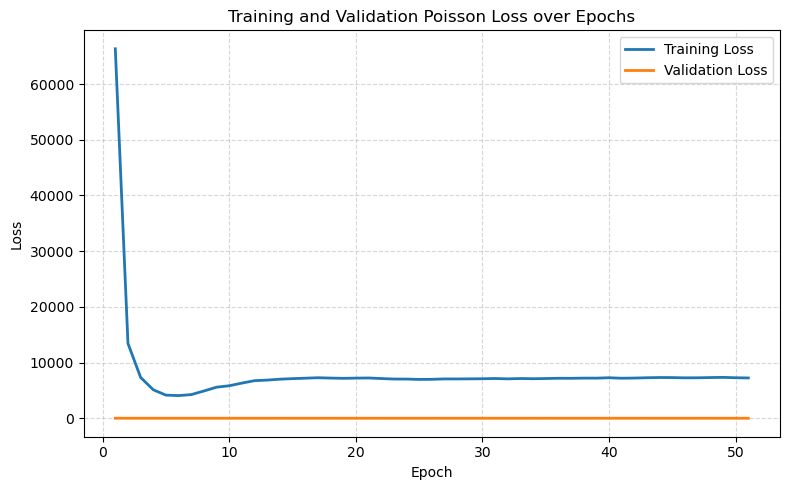

In [29]:
plot_training_history(training_history)


-----------
# 8. Most Exciting Input

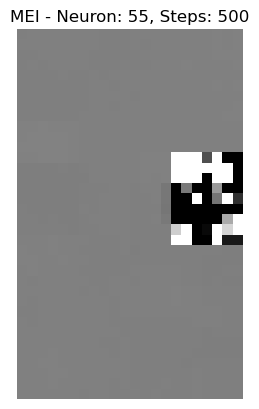

In [30]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 500
neuron_idx = 55
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device,
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

-----------
# 9. Use MEI in the model

In [31]:
# 1. Fetch a stimulus image from the dataset
random_dataset_indx = torch.randint(training_images.shape[0], (1,))
dataset_image = training_images[random_dataset_indx].to(device)

# 2. Generate a completely random image
random_image = torch.randn(image_shape, device=device) * 0.1

# 3. Test dataset image, random image and MEI image and compare predictions
pred_random = model(random_image)[0, 0, neuron_idx]
pred_dataset = model(dataset_image)[0, 0, neuron_idx]
pred_mei = model(mei)[0, 0, neuron_idx]

pred_random, pred_dataset, pred_mei

(tensor(2.1868, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(2.1470, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(2.1875, device='mps:0', grad_fn=<SelectBackward0>))